# Term 1 - Lane Detection using Computer Vision

Identifying lanes on the road is a common task performed by all human drivers to ensure their vehicles are within lane constraints when driving, so as to make sure traffic is smooth and minise chances of collisions with other cars due to lane misalignment.

Similarly, it is a critical task for an autonomous vehicle to perform. It turns out that recognising lane markings on roads is possible using well known computer vision techniques. Some of those techniques will be covered below.

This is the first project of the Term 1 of the [Udacity Self Driving Car Engineer Nanodegree](https://www.udacity.com/course/self-driving-car-engineer-nanodegree--nd013). 

# Loading Original Images

Our first step is to load the test images and visualise them.

In [1]:
#importing some useful packages
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

# Making sure we import our images with the right names
test_img_dir = "test_images/"
original_image_names = os.listdir(test_img_dir)
original_image_names = list(map(lambda name: test_img_dir + name, original_image_names))
print(original_image_names)

['test_images/solidWhiteCurve.jpg', 'test_images/solidWhiteRight.jpg', 'test_images/solidYellowCurve.jpg', 'test_images/solidYellowCurve2.jpg', 'test_images/solidYellowLeft.jpg', 'test_images/video_challenge_1s.jpg', 'test_images/video_challenge_2s.jpg', 'test_images/video_challenge_5s.jpg', 'test_images/video_challenge_6s.jpg', 'test_images/video_yellow_lane_left_12s.jpg', 'test_images/video_yellow_lane_left_13s.jpg', 'test_images/video_yellow_lane_left_3s.jpg', 'test_images/video_yellow_lane_left_4s.jpg', 'test_images/video_yellow_lane_left_5s.jpg', 'test_images/video_yellow_lane_left_6s.jpg', 'test_images/whiteCarLaneSwitch.jpg']


In [2]:
# Convenience function used to show a list of images
def show_image_list(img_list, cols=2, fig_size=(15, 15)):
    img_count = len(img_list)
    rows = img_count / cols
    cmap = None
    plt.figure(figsize=fig_size)
    for i in range(0, img_count):
        plt.subplot(rows, cols, i+1)
        img = img_list[i]
        if len(img.shape) < 3:
            cmap = "gray"
        plt.imshow(img, cmap=cmap)

    plt.tight_layout()
    plt.show()

Total image count:  16


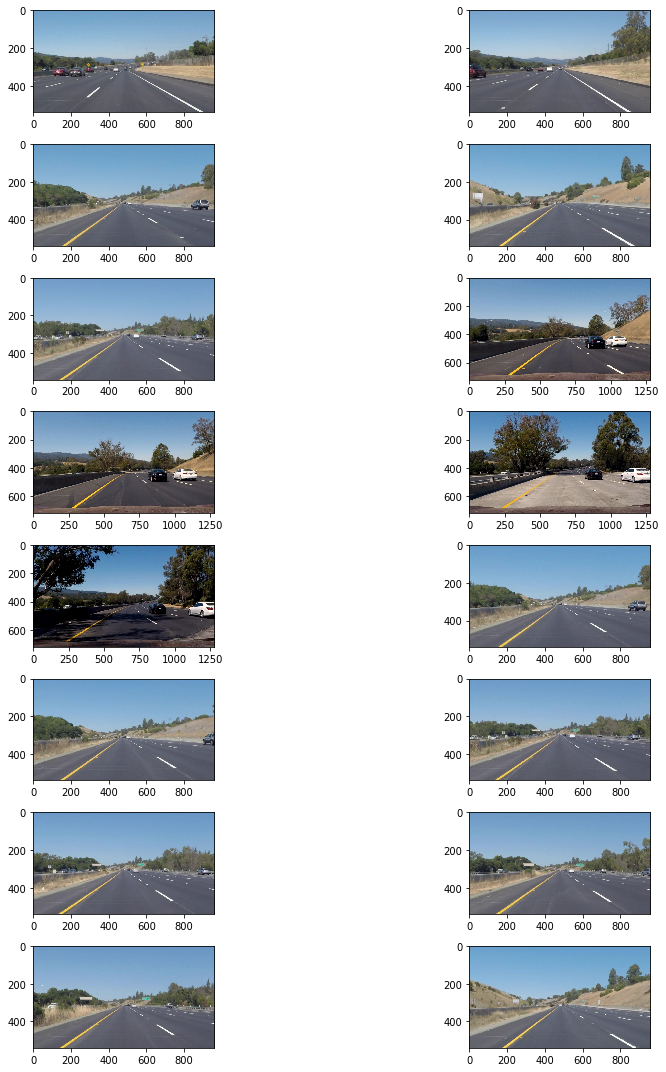

In [3]:
original_images = list(map(lambda img_name: mpimg.imread(img_name), original_image_names))
print("Total image count: ", len(original_images))
show_image_list(original_images)

Let's print the dimensions of one of our images

In [4]:
img_shape = original_images[0].shape
img_shape

(540, 960, 3)

The above shows an image of height width x height of 960 x 540 (this order is reversed in the call to `shape` above). The 3 at the end indicates that we are dealing with a color image where the 3 channels are simply the RGB channels.

# Pipeline 

In this part, we will cover in detail the different steps needed to create our pipeline, which will enable us to identify and classify lane lines. The pipeline itself will look as follows:
* Convert image to grayscale for easier manipulation
* Apply Gaussian Blur to smoothen edges
* Apply Canny Edge Detection on smoothed gray image
* Trace Region Of Interest and discard all other lines identified by our previous step that are outside this region
* Perform a Hough Transform to find lanes within our region of interest and trace them in red
* Separate left and right lanes
* Extrapolate them to create two smooth lines 

## Convert to Grayscale

We are interested in detecting white or yellow lines on images, which show a particularly high contrast when the image is in grayscale. Remember that the road is black, so anything that is much brighter on the road will come out with a high contrast in a grayscale image 

In [5]:
def grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

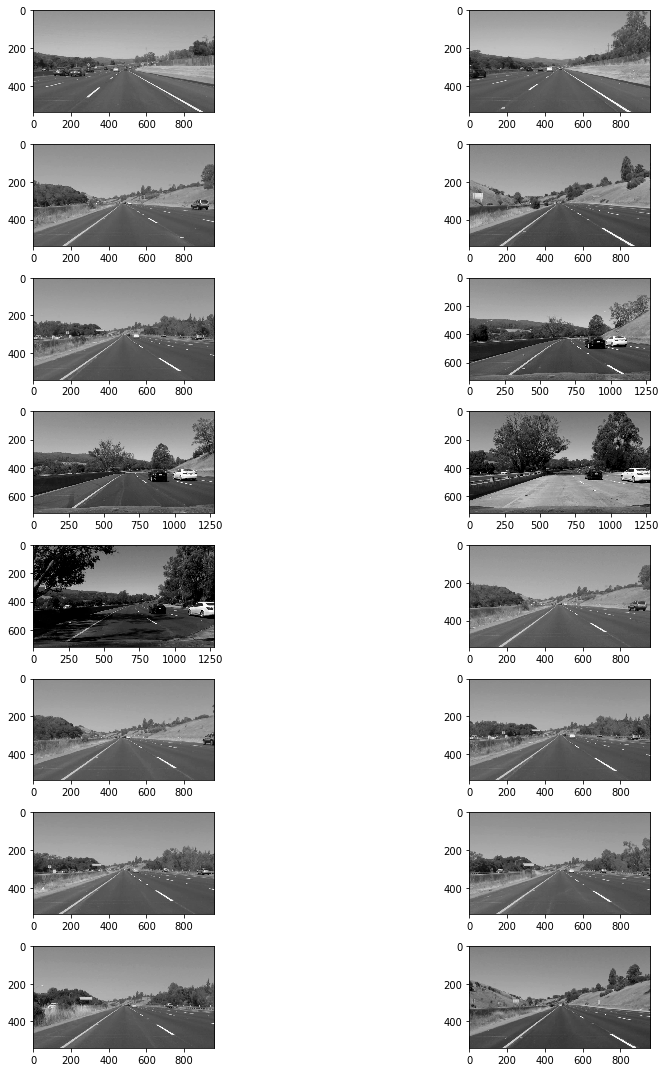

In [6]:
grayscale_images = list(map(lambda img: grayscale(img), original_images))
show_image_list(grayscale_images)

As stated above, colored lane lines contrast highly with the black of the road.

## Gaussian Blur

[Gaussian blur](https://en.wikipedia.org/wiki/Gaussian_blur) (also refered to as Gaussian smoothing) is a pre-processing technique used to smoothen the edges of an image to reduce noise.
The images below show what a typical Gaussian blur does to an image:
<figure>
 <img src="https://upload.wikimedia.org/wikipedia/commons/6/62/Cappadocia_Gaussian_Blur.svg" width="380" height="300" alt="Gaussian Blur" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Original image against Gaussian blurred variants </p> 
 </figcaption>
</figure>

It is possible to choose the intensity of the blur by specifying a *kernel* parameter, which is an odd number.

In [7]:
def gaussian_blur(grayscale_img, kernel_size=3):
    return cv2.GaussianBlur(grayscale_img, (kernel_size, kernel_size), 0) 

We will show how different blurs affect the image

In [8]:
blurred_images1 = list(map(lambda img: gaussian_blur(img, kernel_size=5), grayscale_images))
blurred_images2 = list(map(lambda img: gaussian_blur(img, kernel_size=11), grayscale_images))
blurred_images3 = list(map(lambda img: gaussian_blur(img, kernel_size=21), grayscale_images))

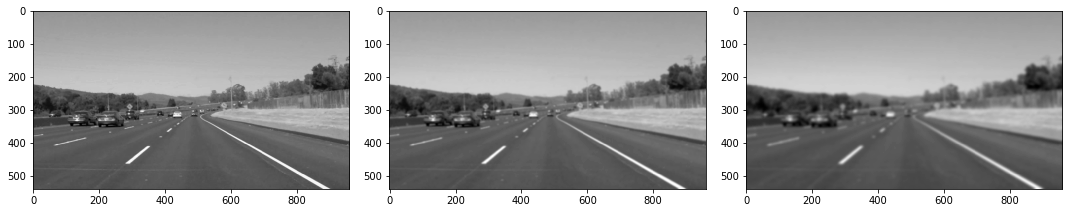

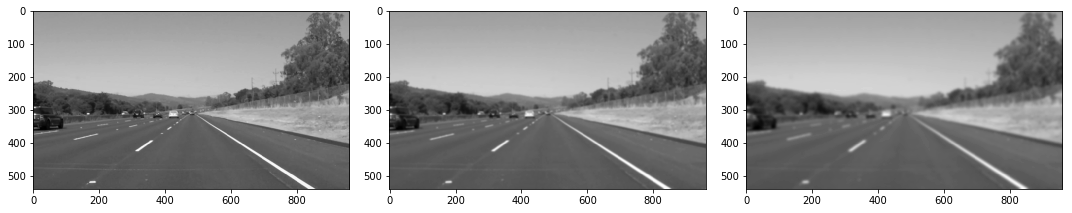

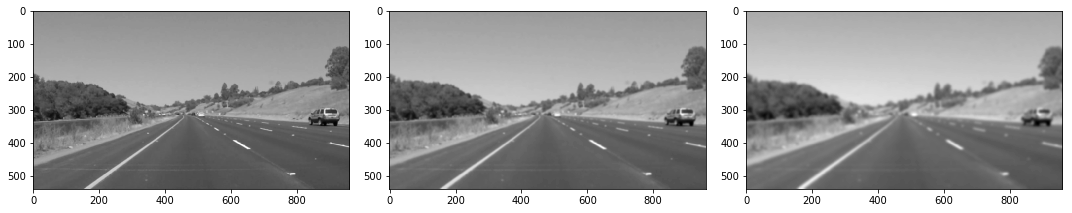

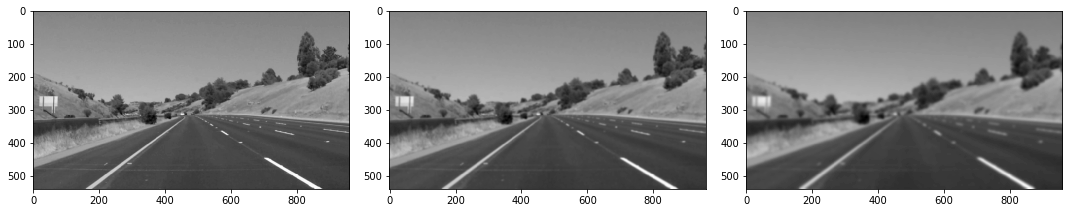

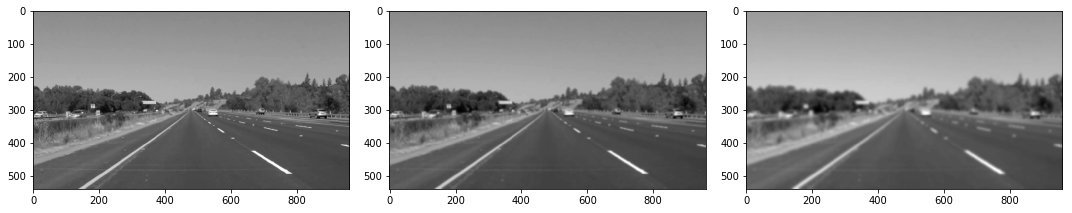

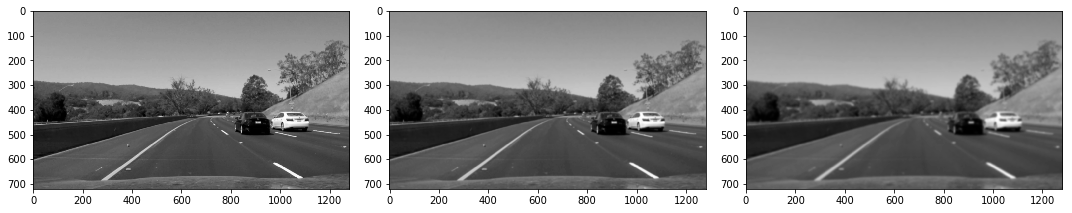

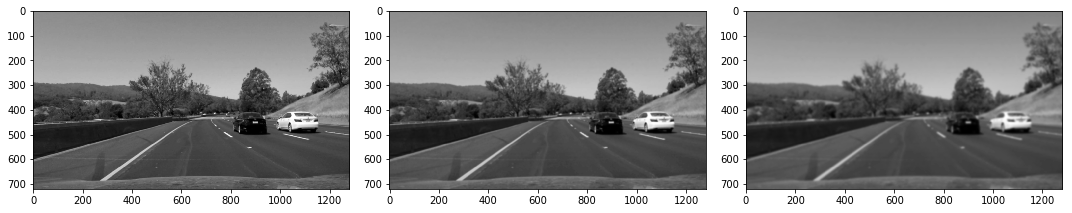

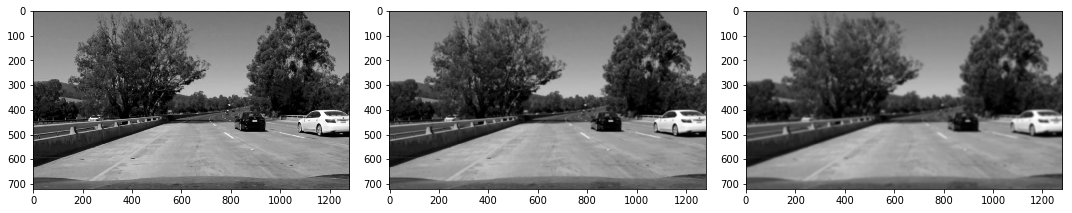

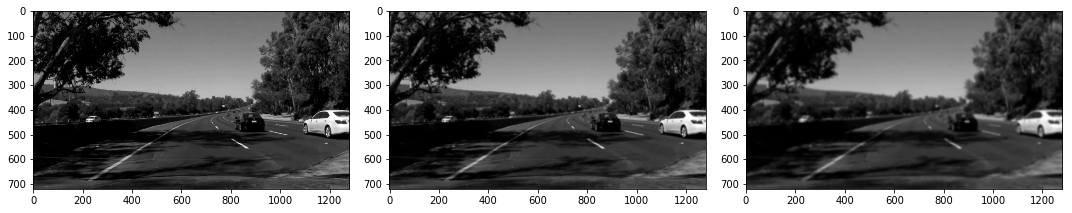

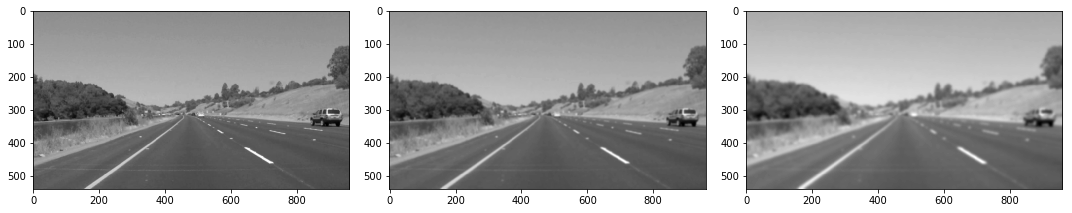

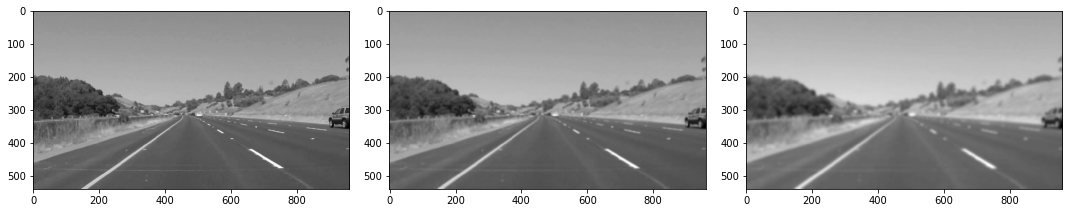

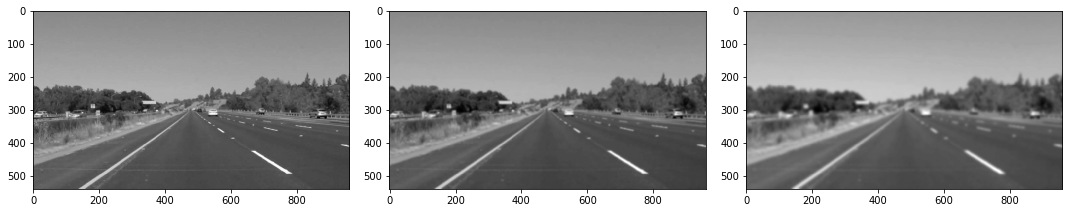

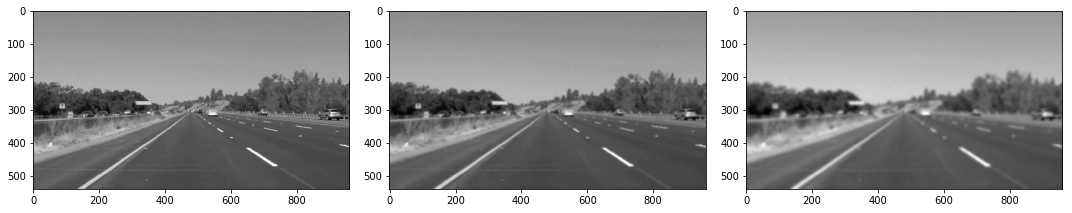

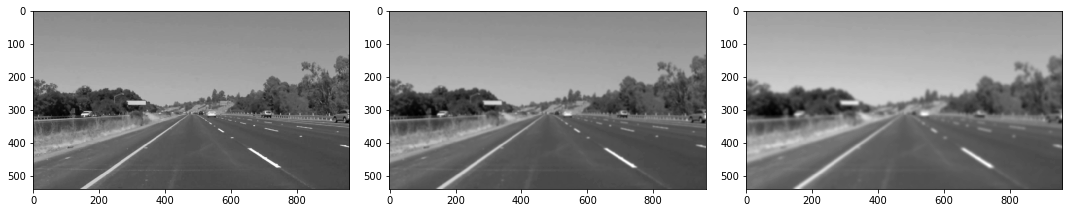

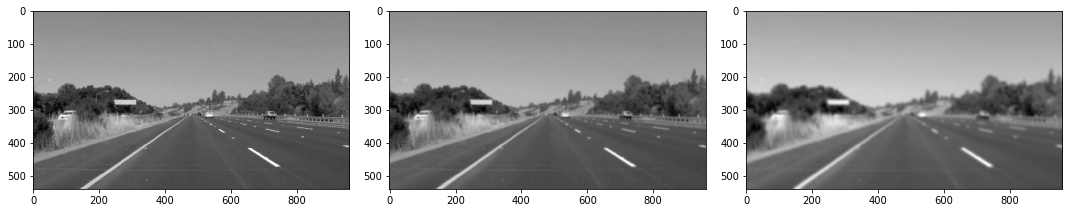

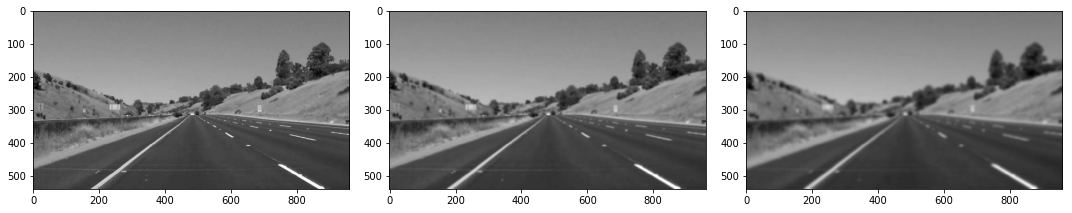

In [9]:
img_count = len(blurred_images1)
interleaved_blur = list(zip(blurred_images1, blurred_images2, blurred_images3))

for blurs in interleaved_blur:
    show_image_list(blurs, cols=3, fig_size=(15, 15))

We can see how increasing the kernel makes the image more blurry. For our task, we will choose a kernel size of 5 for our gaussian blur (images on the left).

## Canny Edge Detection

Now that we have sufficiently pre-processed the image, we can apply a [Canny Edge Detector](https://en.wikipedia.org/wiki/Canny_edge_detector), whose role it is to identify lines in an image and discard all other data. The resulting image ends up being _wiry_, which enables us to focus on lane detection even more, since we are concerned with lines.

The OpenCV implementation requires passing in two parameters in addition to our blurred image, a low and high threshold which determine whether to include a given edge or not. A threshold captures the intensity of change of a given point (you can think of it as a gradient). Any point beyond the high threshold will be included in our resulting image, while points between the threshold values will only be included if they are next to edges beyond our high threshold. Edges that are below our low threshold are discarded. Recommended low:high threshold rations are 1:3 or 1:2.

In [10]:
def canny_edge_detector(blurred_img, low_threshold, high_threshold):
    return cv2.Canny(blurred_img, low_threshold, high_threshold)

In [11]:
canny_images1 = list(map(lambda img: canny_edge_detector(img, 50, 150), blurred_images1)) 
canny_images2 = list(map(lambda img: canny_edge_detector(img, 0, 10), blurred_images1)) 
canny_images3 = list(map(lambda img: canny_edge_detector(img, 10, 50), blurred_images1)) 

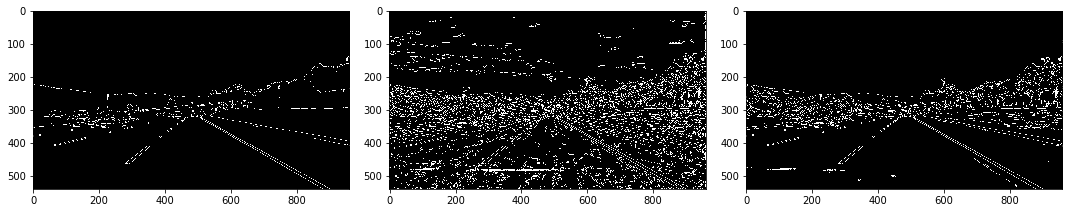

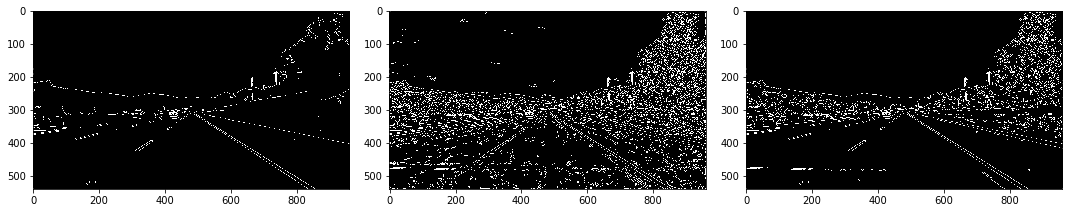

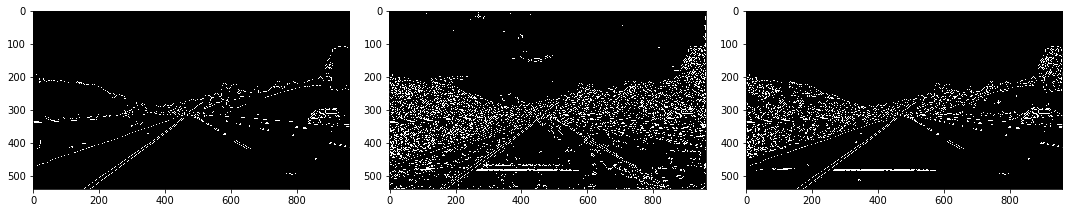

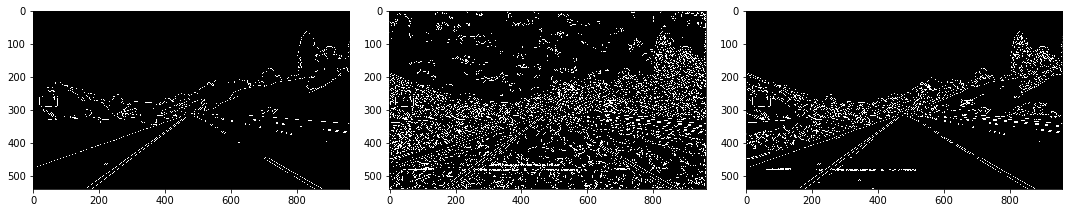

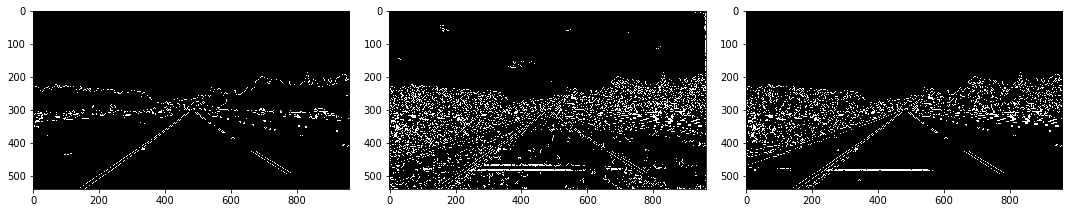

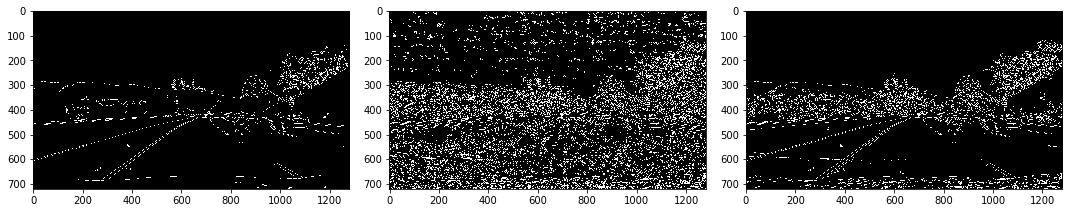

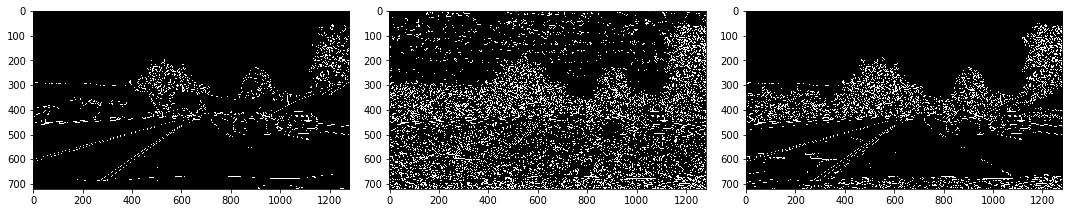

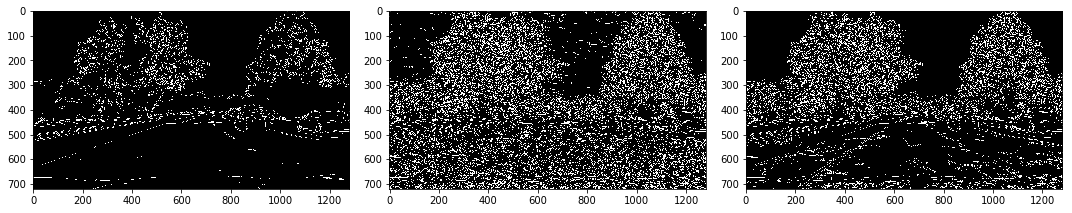

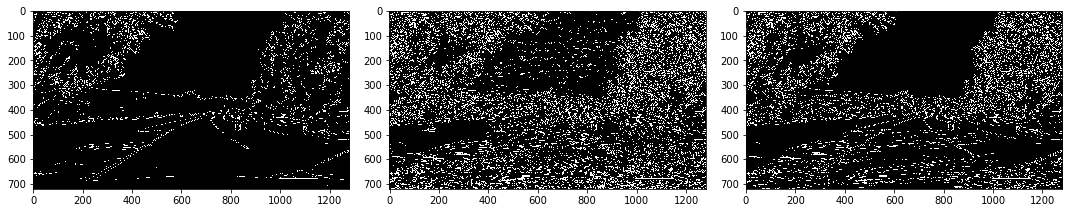

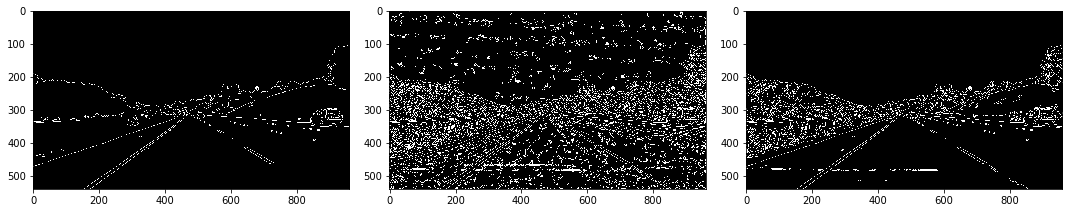

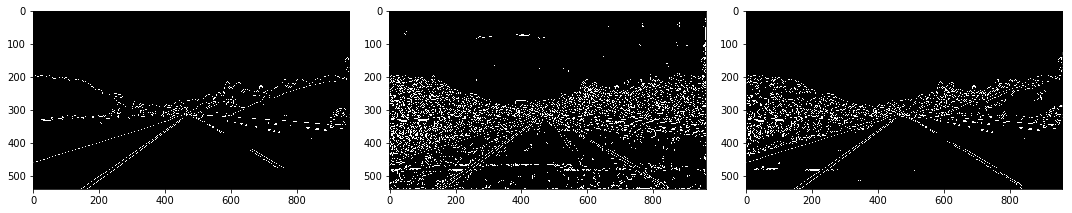

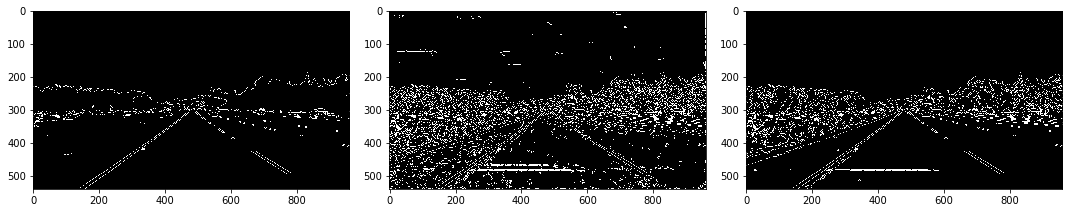

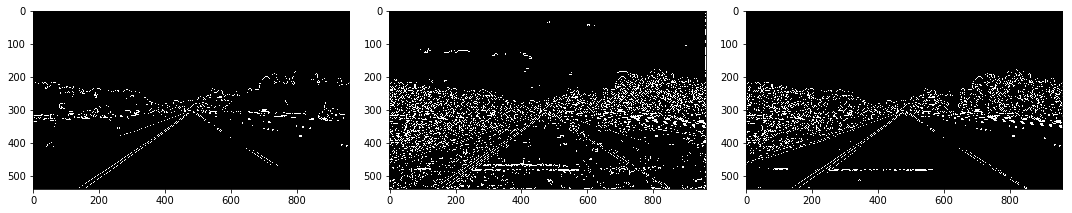

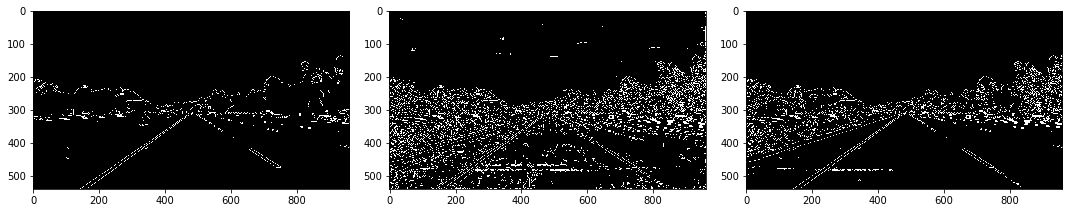

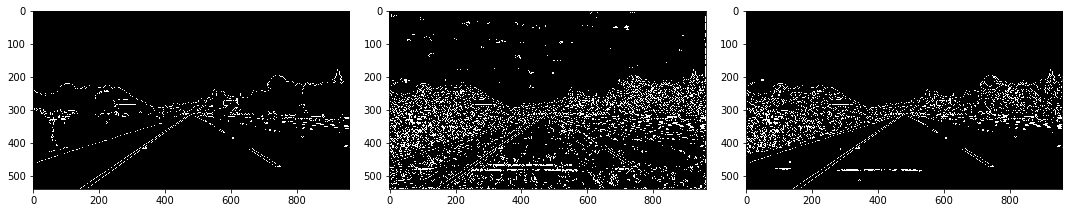

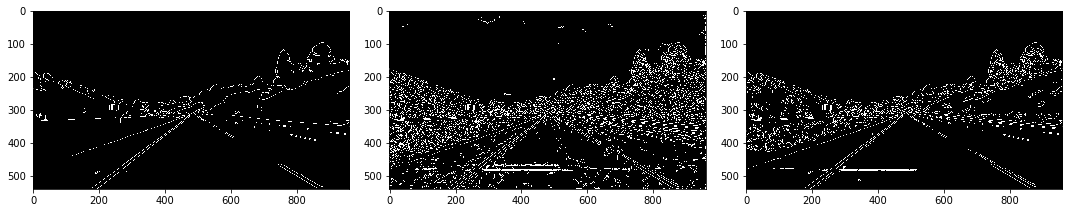

In [12]:
img_count = len(canny_images1)
interleaved_canny = list(zip(canny_images1, canny_images2, canny_images3))

for cannys in interleaved_canny:
    show_image_list(cannys, cols=3, fig_size=(15, 15))

The above figure shows a images resulting from a canny detector process using different threshold parameters. Naturally, we will opt for the images with threshold parameters (50, 150) as they exhibit the least noise.

## Region Of Interest

Our next step is to determine a region of interest and discard any lines outside of this polygon. One crucial assumption in this task is that the camera remains in the sample place across all these image, and lanes are flat, therefore we can identify the critical region we are interested in.

Looking at the above images, we "guess" what that region may be by following the contours of the lanes the car is in and define a polygon which will act as our region of interest below.

In [13]:
def get_vertices_for_img(img):
    imshape = img.shape
    height = imshape[0]
    width = imshape[1]

    vert = None
    
    if (width, height) == (960, 540):
        region_bottom_left = (130 ,img_shape[0] - 1)
        region_top_left = (410, 330)
        region_top_right = (650, 350)
        region_bottom_right = (img_shape[1] - 30,img_shape[0] - 1)
        vert = np.array([[region_bottom_left , region_top_left, region_top_right, region_bottom_right]], dtype=np.int32)
    else:
        region_bottom_left = (170 , 650)
        region_top_left = (500, 500)
        region_top_right = (900, 450)
        region_bottom_right = (width - 80, 650)
        vert = np.array([[region_bottom_left , region_top_left, region_top_right, region_bottom_right]], dtype=np.int32)

    return vert

def region_of_interest(img):
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
        
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    vert = get_vertices_for_img(img)    
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vert, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

In [14]:
segmented_images = list(map(lambda img: region_of_interest(img), canny_images1))
canny_segmented_images = list(zip(canny_images1, segmented_images))

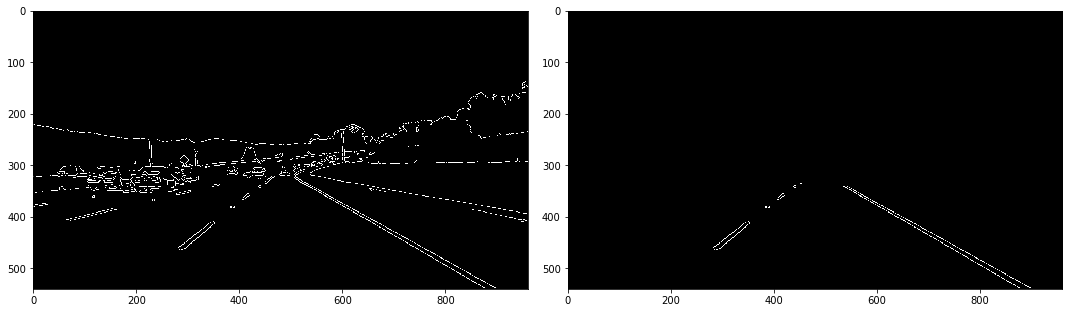

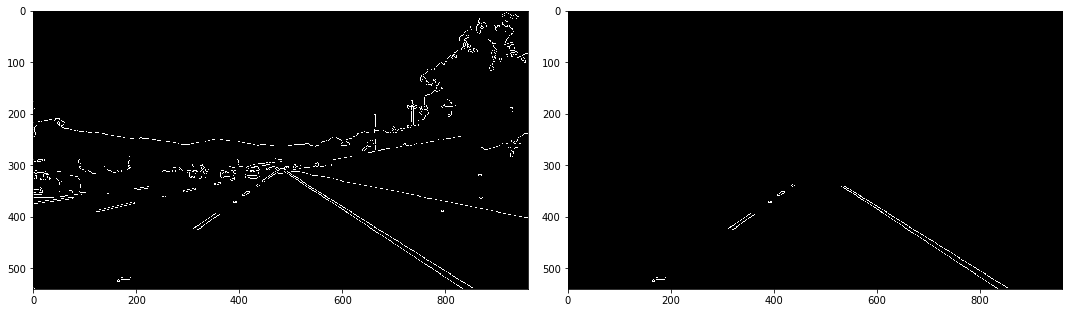

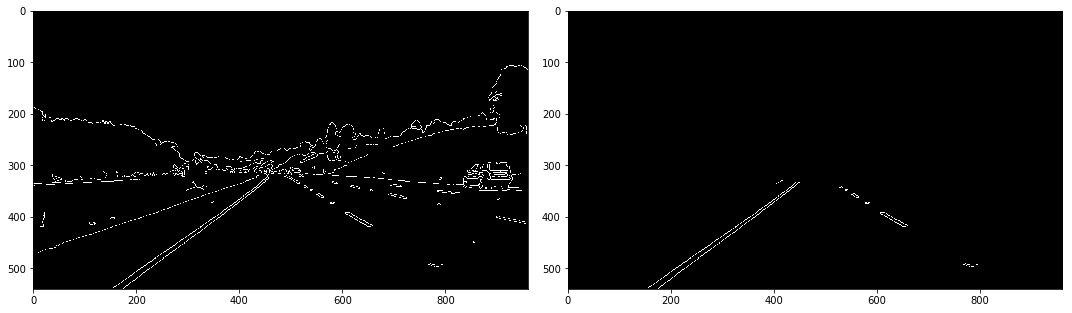

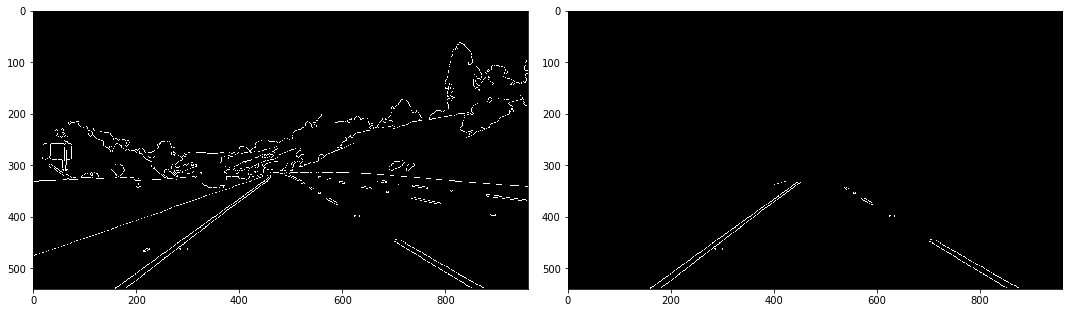

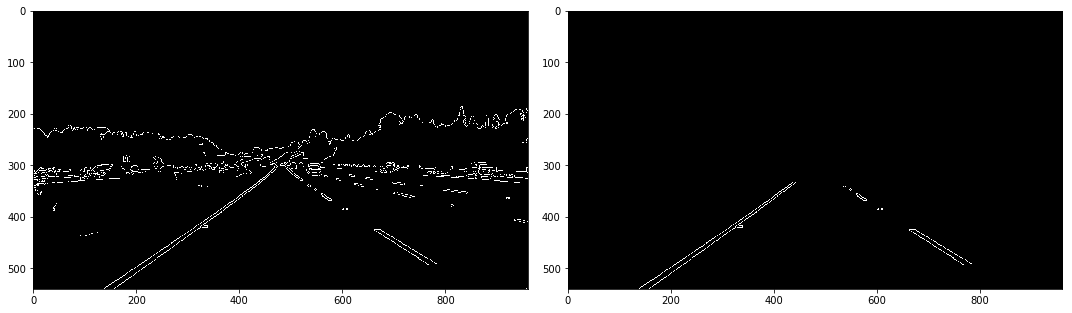

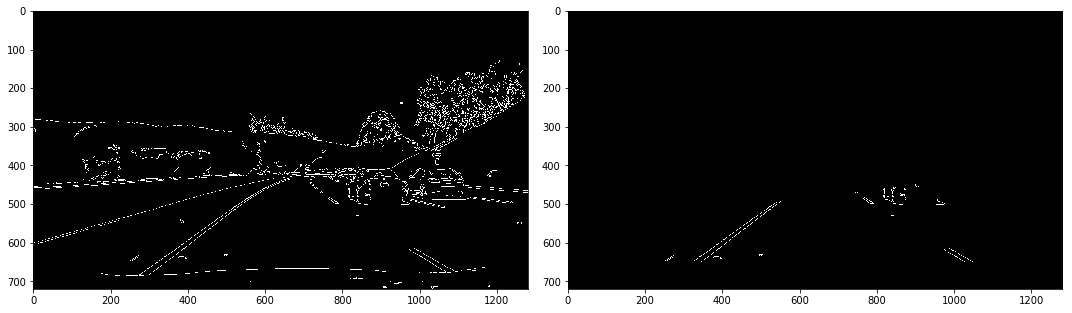

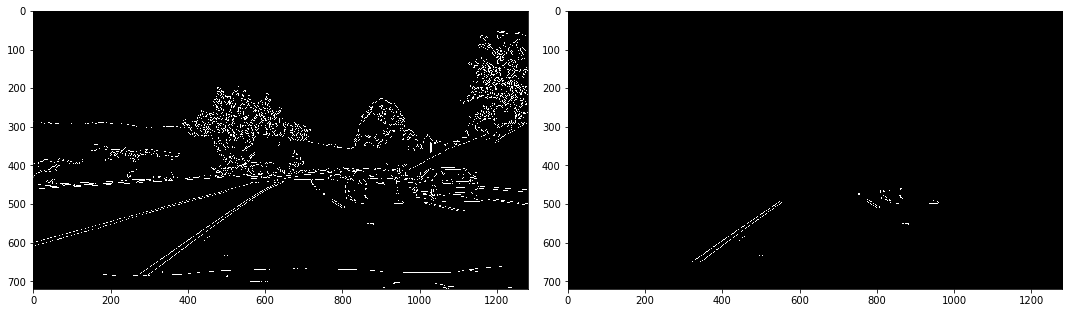

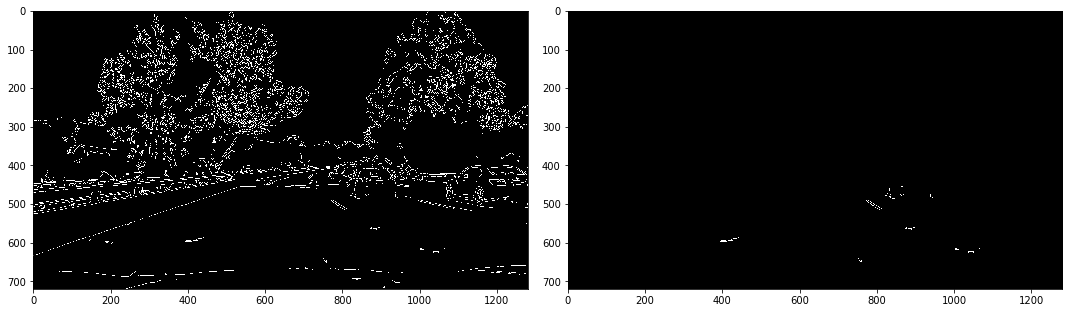

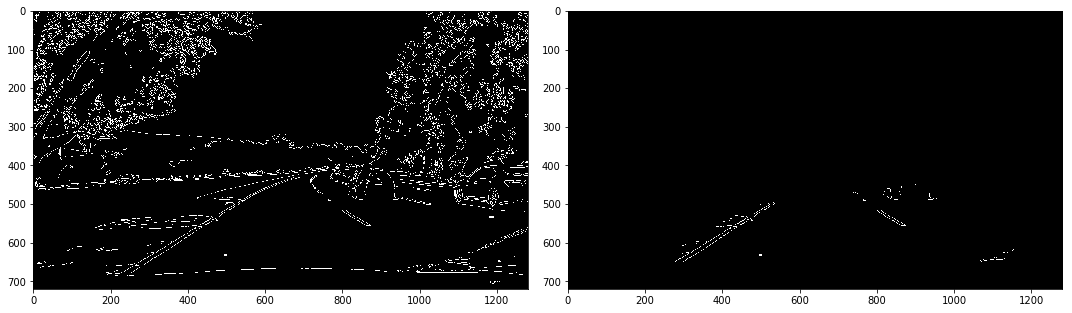

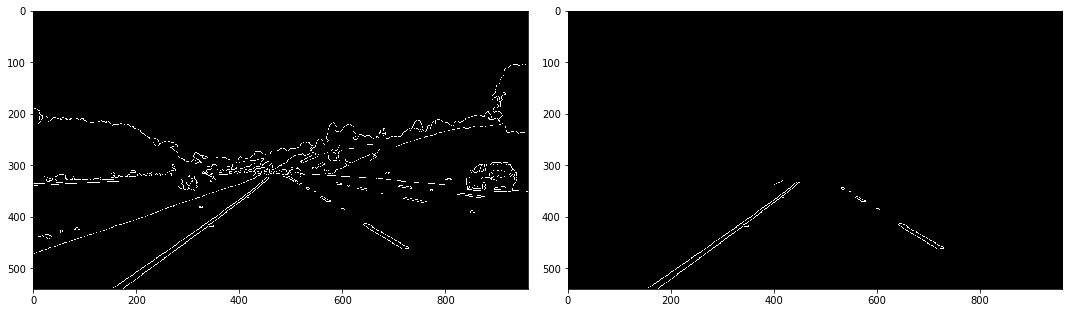

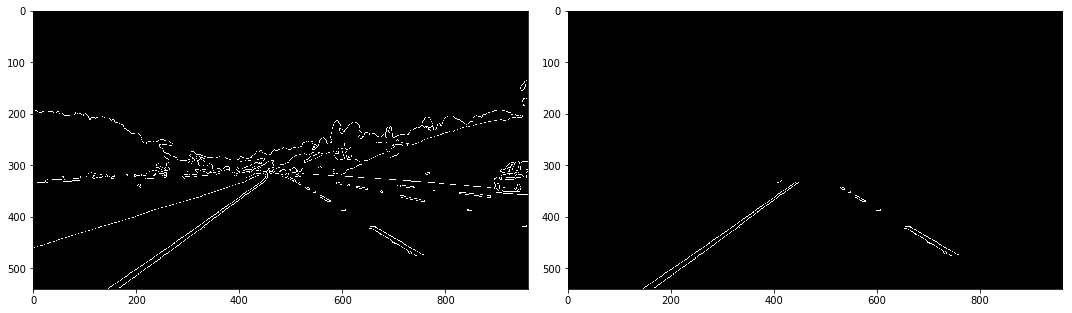

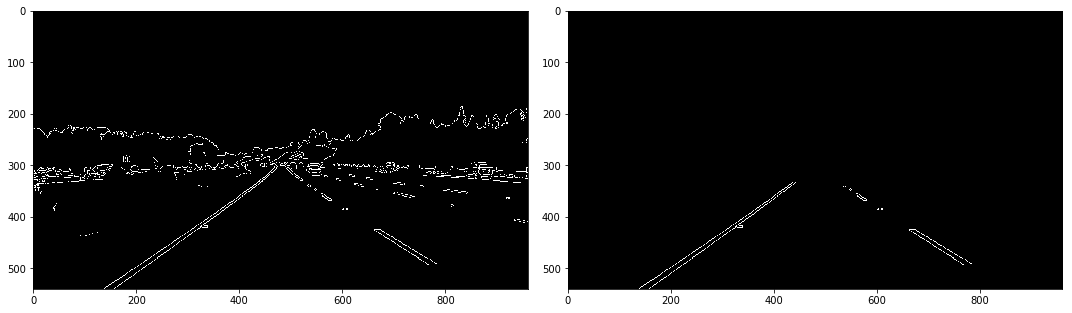

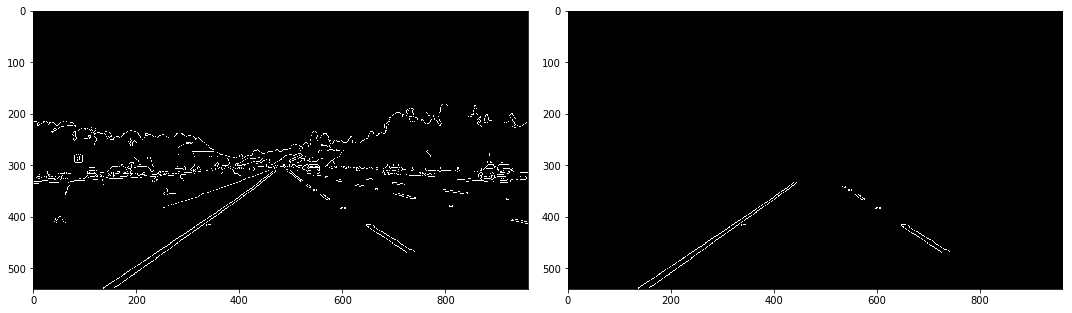

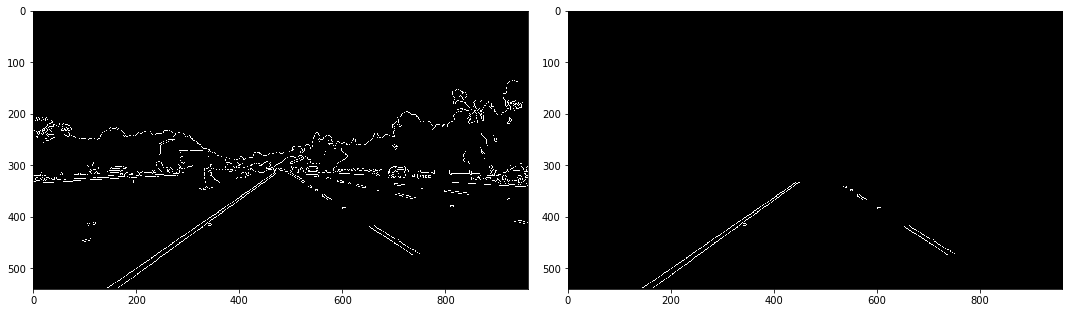

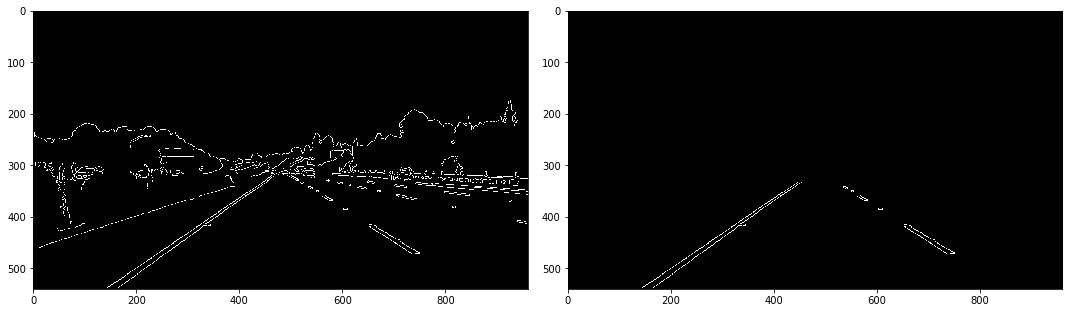

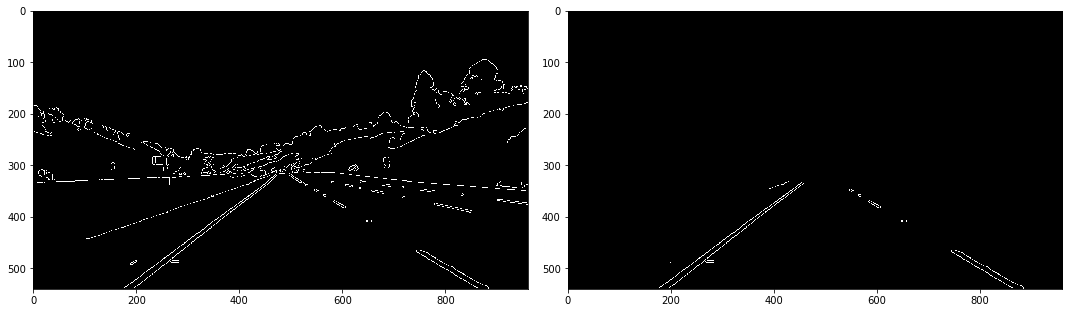

In [15]:
for canny_segmented_img in canny_segmented_images: 
    show_image_list(canny_segmented_img)

## Hough Transform

The next step is to apply the [Hough Transform](https://en.wikipedia.org/wiki/Hough_transform) technique to extract lines and color them. The goal of Hough Transform is to find lines by identifiying all points that lie on them. This is done by converting our current system denoted by axis (x,y) to a _parametric_ one where axes are (m, b). In this plane:
 * lines are represented as points
 * points are presented as lines (since they can be on many lines in traditional coordinate system)
 * intersecting lines means the same point is on multiple lines

Therefore, in such plane, we can more easily identify lines that go via the same point. We however need to move from the current system to a _Hough Space_ which uses _polar coordinates_ one as our original expression is not differentiable when m=0 (i.e. vertical lines). In polar coordinates, a given line will now be expressed as (ρ, θ), where line L is reachable by going a distance ρ at angle θ from the origin, thus meeting the perpendicular L; that is ρ = x cos θ + y sin θ. 
All straight lines going through a given point will correspond to a sinusoidal curve in the (ρ, θ) plane. Therefore, a set of points on the same straight line in Cartesian space will yield sinusoids that cross at the point (ρ, θ). This naturally means that the problem of detecting points on a line in cartesian space is reduced to finding intersecting sinusoids in Hough space.

<figure>
 <img src="docs/hough_and_cartesian_spaces.png" width="380" alt="Hough and Cartesian systems" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Hough and Cartesian systems</p> 
 </figcaption>
</figure>

The Hough transform algorithm implemented in OpenCV is described below (full documentation available [here](http://docs.opencv.org/trunk/d6/d10/tutorial_py_houghlines.html)): 

> Now let's see how the Hough Transform works for lines. Any line can be represented in these two terms, (ρ,θ). So first it creates a 2D array or accumulator (to hold the values of the two parameters) and it is set to 0 initially. Let rows denote the ρ and columns denote the θ. Size of array depends on the accuracy you need. Suppose you want the accuracy of angles to be 1 degree, you will need 180 columns. For ρ, the maximum distance possible is the diagonal length of the image. So taking one pixel accuracy, the number of rows can be the diagonal length of the image.

> Consider a 100x100 image with a horizontal line at the middle. Take the first point of the line. You know its (x,y) values. Now in the line equation, put the values θ=0,1,2,....,180 and check the ρ you get. For every (ρ,θ) pair, you increment value by one in our accumulator in its corresponding (ρ,θ) cells. So now in accumulator, the cell (50,90) = 1 along with some other cells.

> Now take the second point on the line. Do the same as above. Increment the values in the cells corresponding to (rho, theta) you got. This time, the cell (50,90) = 2. What you actually do is voting the (ρ,θ) values. You continue this process for every point on the line. At each point, the cell (50,90) will be incremented or voted up, while other cells may or may not be voted up. This way, at the end, the cell (50,90) will have maximum votes. So if you search the accumulator for maximum votes, you get the value (50,90) which says, there is a line in this image at a distance 50 from the origin and at angle 90 degrees. It is well shown in the below animation

<figure>
 <img src="docs/houghlines_demo.gif" width="380" alt="Hough Transform in action" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Hough Transform in Action</p> 
 </figcaption>
</figure>



The OpenCV Probabilistic Hough Transform requires the following parameters:
* ρ and θ for accuracy
* a threshold value which indicates the minimum number of votes to detect a line (i.e. how many intersecting sinusoidals)
* a minimum line length: shorter lines will be rejected by the algorithm
* a maximum line gap: maximum gap allowed between line segments to treat them as a single line

In [16]:
def hough_transform(canny_img, rho, theta, threshold, min_line_len, max_line_gap):
    return cv2.HoughLinesP(canny_img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)

In [17]:
rho = 1
# 1 degree
theta = (np.pi/180) * 1
threshold = 15
min_line_length = 20
max_line_gap = 75

In [18]:
hough_lines_per_image = list(map(lambda img: hough_transform(img, rho, theta, threshold, min_line_length, max_line_gap), 
                                 segmented_images))

## Separating Left And Right Lanes

### Drawing Lines

Let's see what lines `hough_transform` function has identified:

In [19]:
def draw_lines(img, lines, color=[255, 0, 0], thickness=15, make_copy=True):
    # Copy the passed image
    img_copy = np.copy(img) if make_copy else img
    
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img_copy, (x1, y1), (x2, y2), color, thickness)
    
    return img_copy

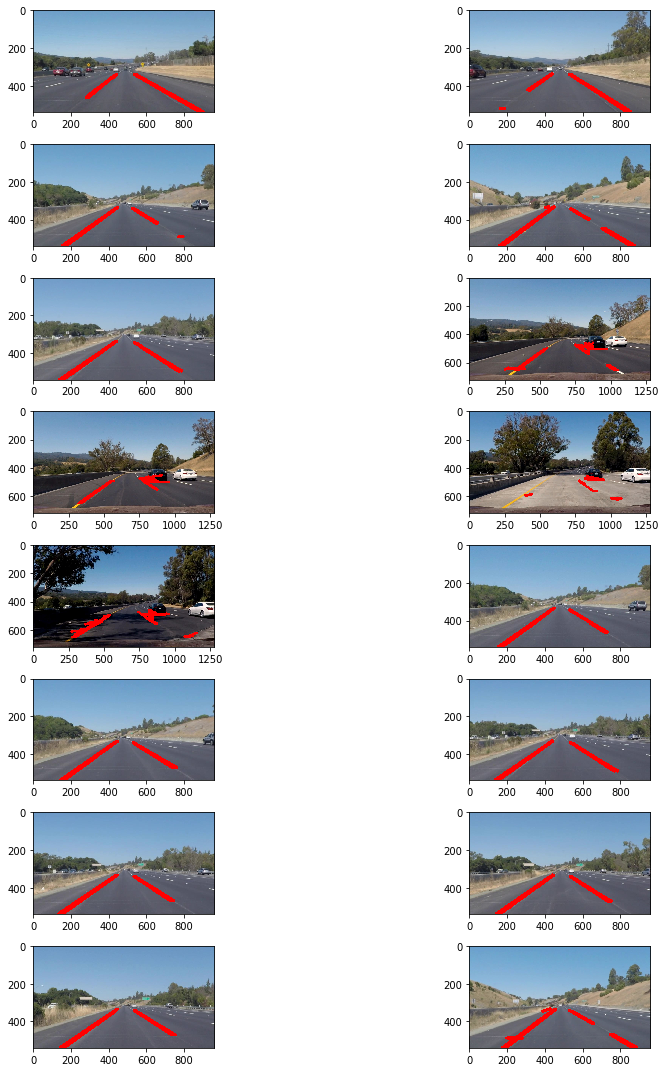

In [20]:
img_with_lines = list(map(lambda img, lines: draw_lines(img, lines), original_images, hough_lines_per_image))    
show_image_list(img_with_lines)

The lanes are very clearly identified. There is one image where a small patch of lane has been rejected by the algorithm, due to the high threshold I specified. That's still ok as the bigger lane line was correctly identified.

### Separating Left And Right Lanes

To be able to trace a full line and connect lane markings on the image, we must be able to distinguish left from right lanes. Fortunately, there is a trivial way to do so. If you carefully look the image (may be easier with the canny segmented images), you can derive the gradient (i.e slope) of any left or right lane line:
* left lane: **as x value (i.e. width) increases, y value (i.e. height) decreases: slope must thus be negative**
* right lane:**as x value (i.e. width) increases, y value (i.e. height) increases: slope must thus be positive**

We can therefore define a function that separates lines into a left and right one

In [21]:
def separate_lines(lines):
    left_lane_lines = []
    right_lane_lines = []

    for line in lines:
        for x1, y1, x2, y2 in line:
            dx = x2 - x1 
            if dx == 0:
                #Discarding line since we can't gradient is undefined at this dx
                continue
            dy = y2 - y1
            
            # Similarly, if the y value remains constant as x increases, discard line
            if dy == 0:
                continue
            
            slope = dy / dx
            
            # This is pure guess than anything... 
            # but get rid of lines with a small slope as they are likely to be horizontal one
            epsilon = 0.1
            if abs(slope) <= epsilon:
                continue
            
            if slope < 0:
                # Lane should also be within the left hand side of region of interest
                left_lane_lines.append([[x1, y1, x2, y2]])
            else:
                # Lane should also be within the right hand side of region of interest
                right_lane_lines.append([[x1, y1, x2, y2]])
    
    return left_lane_lines, right_lane_lines

In [22]:
separated_lanes_per_image = list(map(lambda lines: separate_lines(lines), hough_lines_per_image))

In [23]:
def color_lanes(img, left_lane_lines, right_lane_lines, left_lane_color=[255, 0, 0], right_lane_color=[0, 0, 255]):
    left_colored_img = draw_lines(img, left_lane_lines, color=left_lane_color, make_copy=True)
    right_colored_img = draw_lines(left_colored_img, right_lane_lines, color=right_lane_color, make_copy=False)
    
    return right_colored_img

In [24]:
img_different_lane_colors = list(map(lambda img, separated_lanes: color_lanes(img, separated_lanes[0], separated_lanes[1]), original_images, separated_lanes_per_image))

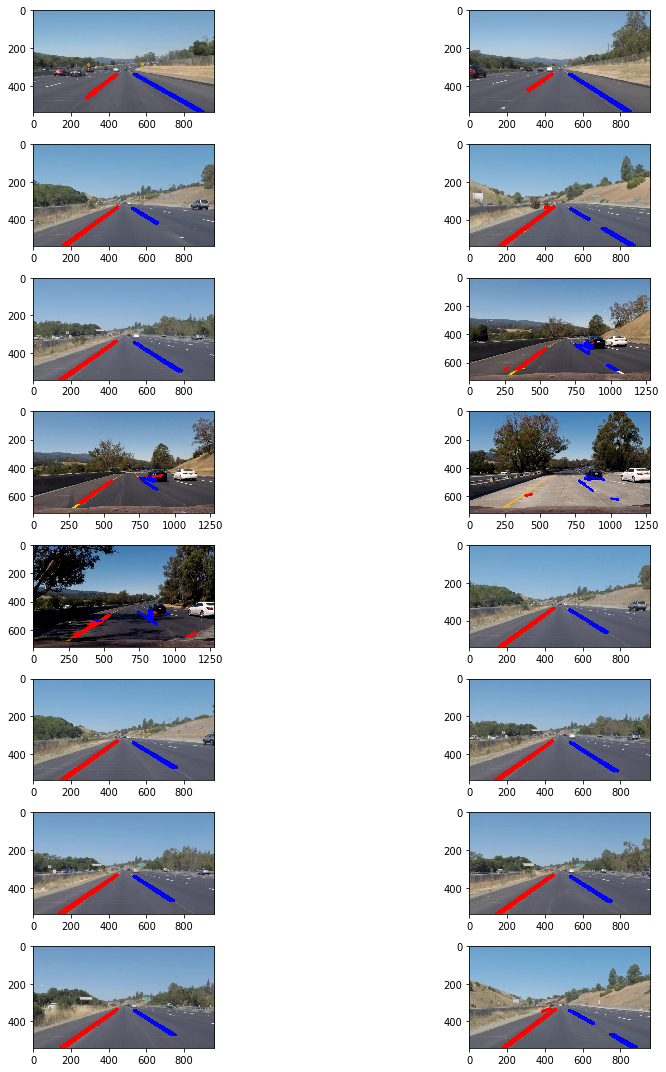

In [25]:
show_image_list(img_different_lane_colors)

As you can see above, left and right lanes are perfectly separated. 

### Lane Extrapolation

To trace a full line from the bottom of the screen to the highest point of our region of interest, we must be able to interpolate the different points on a given lane and find a line that minimise the distance across those points. Basically this is a [linear regression](https://en.wikipedia.org/wiki/Regression_analysis) problem. We will attempt to find the line on a given lane by minimising the [least squares](https://en.wikipedia.org/wiki/Least_squares) error.

In [26]:
from scipy import stats

def find_lane_lines_formula(lines):
    xs = []
    ys = []
    
    for line in lines:
        for x1, y1, x2, y2 in line:
            xs.append(x1)
            xs.append(x2)
            ys.append(y1)
            ys.append(y2)
    
    slope, intercept, r_value, p_value, std_err = stats.linregress(xs, ys)
    
    # Remember, a straight line is expressed as f(x) = Ax + b. Slope is the A, while intercept is the b
    return (slope, intercept)
    

We now define a function to trace a line on the lane:

In [27]:
def trace_lane_line(img, lines, top_y, make_copy=True):
    A, b = find_lane_lines_formula(lines)
    vert = get_vertices_for_img(img)
    
    bottom_y = vert[0][0][1]
    # y = Ax + b, therefore x = (y - b) / A
    x_to_bottom_y = (bottom_y - b) / A
    
    top_x_to_y = (top_y - b) / A 
    
    new_lines = [[[int(x_to_bottom_y), int(bottom_y), int(top_x_to_y), int(top_y)]]]
    return draw_lines(img, new_lines, make_copy=make_copy)

def trace_both_lane_lines(img, left_lane_lines, right_lane_lines):
    vert = get_vertices_for_img(img)
    region_top_left = vert[0][1]
    
    full_left_lane_img = trace_lane_line(img, left_lane_lines, region_top_left[1], make_copy=True)
    full_left_right_lanes_img = trace_lane_line(full_left_lane_img, right_lane_lines, region_top_left[1], make_copy=False)
    
    # image1 * α + image2 * β + λ
    # image1 and image2 must be the same shape.
    img_with_lane_weight =  cv2.addWeighted(img, 0.7, full_left_right_lanes_img, 0.3, 0.0)
    
    return img_with_lane_weight

In [28]:
full_lane_drawn_images = list(map(lambda img, separated_lanes : trace_both_lane_lines(img, separated_lanes[0], separated_lanes[1]), 
                                  original_images, separated_lanes_per_image))

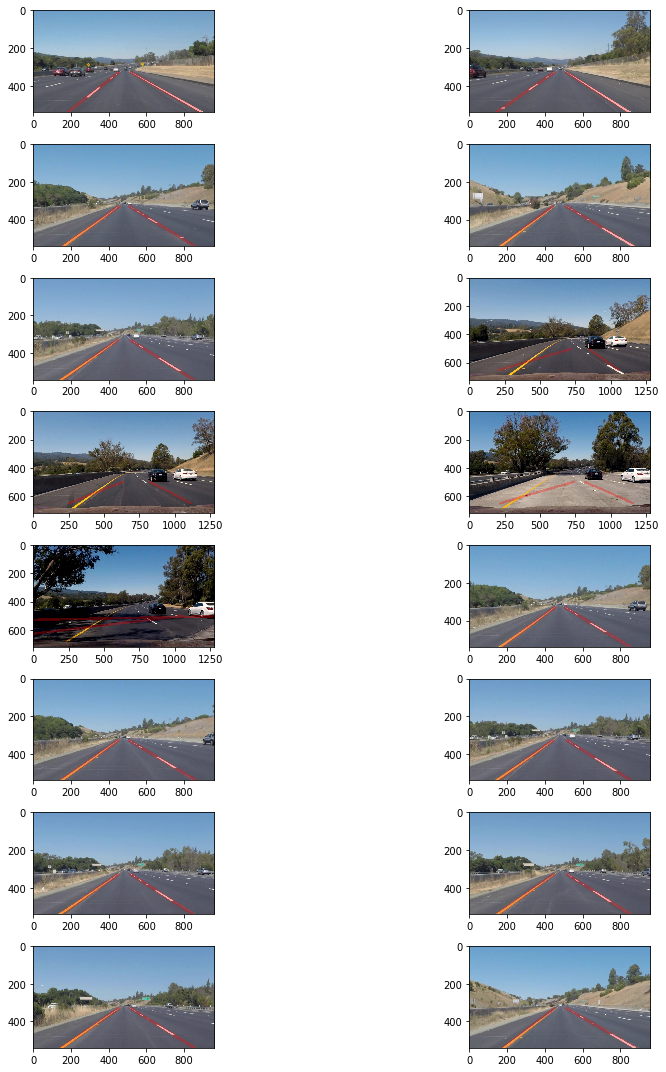

In [29]:
show_image_list(full_lane_drawn_images)

Both lines are very accurately detected and stop at roughly the same y value. We will now move on to detecting lane lines on video.

# Lane Detection On Videos

For this part, we read a video each frame at a time and modify the frame with the overlapping lines. Before, we get started, we must create a `pipeline` function that takes in a frame and returns the processed frame. 

In [30]:
from collections import deque

def create_lane_line_coefficients_list(length = 15):
    return deque(maxlen=length)

In [36]:
def trace_lane_line_with_coefficients(img, line_coefficients, top_y, make_copy=True):
    A = line_coefficients[0]
    b = line_coefficients[1]
    
    bottom_y = img_shape[0] - 1
    # y = Ax + b, therefore x = (y - b) / A
    x_to_bottom_y = (bottom_y - b) / A
    
    top_x_to_y = (top_y - b) / A 
    
    new_lines = [[[int(x_to_bottom_y), int(bottom_y), int(top_x_to_y), int(top_y)]]]
    return draw_lines(img, new_lines, make_copy=make_copy)


def trace_both_lane_lines_with_lines_coefficients(img, left_line_coefficients, right_line_coefficients):
    vert = get_vertices_for_img(img)
    region_top_left = vert[0][1]
    
    full_left_lane_img = trace_lane_line_with_coefficients(img, left_line_coefficients, region_top_left[1], make_copy=True)
    full_left_right_lanes_img = trace_lane_line_with_coefficients(full_left_lane_img, right_line_coefficients, region_top_left[1], make_copy=False)
    
    # image1 * α + image2 * β + λ
    # image1 and image2 must be the same shape.
    img_with_lane_weight =  cv2.addWeighted(img, 0.7, full_left_right_lanes_img, 0.3, 0.0)
    
    return img_with_lane_weight

In [34]:
import math

MAXIMUM_SLOPE_DIFF = 2.0
MAXIMUM_INTERCEPT_DIFF = 100.0

class LaneDetectorWithMemory:
    def __init__(self):
        self.left_lane_coefficients  = create_lane_line_coefficients_list()
        self.right_lane_coefficients = create_lane_line_coefficients_list()
        
        self.previous_left_lane_coefficients = None
        self.previous_right_lane_coefficients = None
        
    
    def mean_coefficients(self, coefficients_queue, axis=0):        
        return [0, 0] if len(coefficients_queue) == 0 else np.mean(coefficients_queue, axis=axis)
    
    def determine_line_coefficients(self, stored_coefficients, current_coefficients):
        if len(stored_coefficients) == 0:
            stored_coefficients.append(current_coefficients) 
            return current_coefficients
        
        mean = self.mean_coefficients(stored_coefficients)
        abs_slope_diff = abs(current_coefficients[0] - mean[0])
        abs_intercept_diff = abs(current_coefficients[1] - mean[1])
        
        if abs_slope_diff > MAXIMUM_SLOPE_DIFF or abs_intercept_diff > MAXIMUM_INTERCEPT_DIFF:
            print("Identified big difference in slope (", current_coefficients[0], " vs ", mean[0],
                 ") or intercept (", current_coefficients[1], " vs ", mean[1], ")")
            # In this case use the mean
            return mean
        else:
            # Save our coefficients and returned a smoothened one
            stored_coefficients.append(current_coefficients)
            return self.mean_coefficients(stored_coefficients)
        

    def lane_detection_pipeline(self, img):
        grayscale_img = grayscale(img)
        gaussian_smoothed_img = gaussian_blur(grayscale_img, kernel_size=5)
        canny_img = canny_edge_detector(gaussian_smoothed_img, 50, 150)
        segmented_img = region_of_interest(canny_img)
        hough_lines = hough_transform(segmented_img, rho, theta, threshold, min_line_length, max_line_gap)

        #try:
        left_lane_lines, right_lane_lines = separate_lines(hough_lines)
        left_lane_slope, left_intercept = find_lane_lines_formula(left_lane_lines)
        right_lane_slope, right_intercept = find_lane_lines_formula(right_lane_lines)
        smoothed_left_lane_coefficients = self.determine_line_coefficients(self.left_lane_coefficients, [left_lane_slope, left_intercept])
        smoothed_right_lane_coefficients = self.determine_line_coefficients(self.right_lane_coefficients, [right_lane_slope, right_intercept])
        img_with_lane_lines = trace_both_lane_lines_with_lines_coefficients(img, smoothed_left_lane_coefficients, smoothed_right_lane_coefficients)
        
        return img_with_lane_lines

        #except Exception in e:
         #   print("*** Error - will use saved coefficients ", e)
          #  smoothed_left_lane_coefficients = self.determine_line_coefficients(self.left_lane_coefficients, [0.0, 0.0])
           # smoothed_right_lane_coefficients = self.determine_line_coefficients(self.right_lane_coefficients, [0.0, 0.0])
            #img_with_lane_lines = trace_both_lane_lines_with_lines_coefficients(img, smoothed_left_lane_coefficients, smoothed_right_lane_coefficients)
        
            #return img_with_lane_lines


        #img_with_lane_lines = trace_both_lane_lines(img, left_lane_lines, right_lane_lines)
#        img_with_lane_lines = trace_both_lane_lines_with_lines_coefficients(img, smoothed_left_lane_coefficients, smoothed_right_lane_coefficients)
        
 #       return img_with_lane_lines
    

## Solid White Lane Markings

This is the first test video, and arguably the easiest.

In [32]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [37]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
detector = LaneDetectorWithMemory()

clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(detector.lane_detection_pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|█████████▉| 221/222 [00:06<00:00, 33.19it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 3.04 s, sys: 777 ms, total: 3.82 s
Wall time: 7.52 s


In [38]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Yellow And White Lane Markings

This second video is slightly more tricky because of the yellow markings

In [39]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')

clip2.save_frame("test_images/video_yellow_lane_left_12s.jpg", t=12) # saves the frame
clip2.save_frame("test_images/video_yellow_lane_left_13s.jpg", t=13) # saves the frame
#clip2.save_frame("test_images/video_yellow_lane_left_5s.jpg", t=5) # saves the frame
#clip2.save_frame("test_images/video_yellow_lane_left_6s.jpg", t=6) # saves the frame

detector = LaneDetectorWithMemory()
yellow_clip = clip2.fl_image(detector.lane_detection_pipeline)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


  6%|▌         | 38/682 [00:01<00:17, 36.26it/s]

Identified big difference in slope ( -0.197440424449  vs  -0.695952842955 ) or intercept ( 507.290763386  vs  641.356447943 )


 16%|█▋        | 111/682 [00:03<00:18, 30.90it/s]

Identified big difference in slope ( 0.153932178647  vs  0.641544158116 ) or intercept ( 350.901836405  vs  -0.999082373212 )
Identified big difference in slope ( -0.0537136263781  vs  -0.685523200435 ) or intercept ( 432.236710134  vs  637.463605808 )


 19%|█▉        | 128/682 [00:04<00:21, 26.26it/s]

Identified big difference in slope ( -0.0938595886577  vs  -0.687836645625 ) or intercept ( 466.68808012  vs  638.441838998 )


 33%|███▎      | 226/682 [00:07<00:14, 31.90it/s]

Identified big difference in slope ( -0.0838068841581  vs  -0.734665264869 ) or intercept ( 450.25273749  vs  660.719489943 )


 44%|████▎     | 298/682 [00:10<00:12, 29.95it/s]

Identified big difference in slope ( 0.112943825613  vs  0.574991423214 ) or intercept ( 370.599716719  vs  38.9373124999 )


 48%|████▊     | 329/682 [00:11<00:12, 27.77it/s]

Identified big difference in slope ( -0.122266479894  vs  -0.716936623327 ) or intercept ( 488.931052598  vs  651.037043595 )


 52%|█████▏    | 353/682 [00:12<00:11, 29.58it/s]

Identified big difference in slope ( -0.0676625857861  vs  -0.684278655151 ) or intercept ( 473.484629632  vs  637.970014589 )


 55%|█████▌    | 376/682 [00:13<00:11, 26.63it/s]

Identified big difference in slope ( -0.215093009384  vs  -0.677983597182 ) or intercept ( 497.477997181  vs  638.262234872 )
Identified big difference in slope ( -0.0192818434687  vs  -0.677983597182 ) or intercept ( 425.929188502  vs  638.262234872 )
Identified big difference in slope ( -0.145598356719  vs  -0.677983597182 ) or intercept ( 483.989942809  vs  638.262234872 )


 66%|██████▋   | 452/682 [00:15<00:07, 32.05it/s]

Identified big difference in slope ( -0.0867121767806  vs  -0.682648445994 ) or intercept ( 457.867975468  vs  634.495028745 )


 70%|██████▉   | 475/682 [00:16<00:06, 30.84it/s]

Identified big difference in slope ( -0.0230549221615  vs  -0.673010810324 ) or intercept ( 442.16762512  vs  631.130053185 )
Identified big difference in slope ( 0.269029694254  vs  0.622414390337 ) or intercept ( 259.438581504  vs  11.3585486807 )


 73%|███████▎  | 499/682 [00:17<00:05, 30.63it/s]

Identified big difference in slope ( -0.116446604588  vs  -0.683896011083 ) or intercept ( 481.876226401  vs  637.605242007 )


 82%|████████▏ | 560/682 [00:19<00:03, 33.04it/s]

Identified big difference in slope ( -0.124269326935  vs  -0.701149262304 ) or intercept ( 496.281177143  vs  647.415226479 )


 85%|████████▍ | 579/682 [00:19<00:03, 30.73it/s]

Identified big difference in slope ( 0.220079191041  vs  0.604662346054 ) or intercept ( 284.768369404  vs  15.5855834857 )


 87%|████████▋ | 594/682 [00:20<00:02, 29.53it/s]

Identified big difference in slope ( 0.374017330185  vs  0.586757794361 ) or intercept ( 162.343566057  vs  23.9663094532 )
Identified big difference in slope ( -0.163457550279  vs  -0.7669240647 ) or intercept ( 487.421939289  vs  674.017899621 )


 88%|████████▊ | 601/682 [00:20<00:02, 27.27it/s]

Identified big difference in slope ( 0.230838011028  vs  0.580751962177 ) or intercept ( 283.060917656  vs  29.6782336032 )


 93%|█████████▎| 637/682 [00:21<00:01, 32.80it/s]

Identified big difference in slope ( 0.214616087058  vs  0.557918154019 ) or intercept ( 274.818229395  vs  42.1321127154 )
Identified big difference in slope ( 0.225401953632  vs  0.557918154019 ) or intercept ( 285.593981828  vs  42.1321127154 )


 99%|█████████▊| 672/682 [00:22<00:00, 31.29it/s]

Identified big difference in slope ( -0.0923534895067  vs  -0.742184955042 ) or intercept ( 466.79355625  vs  663.450123802 )
Identified big difference in slope ( 0.392404516958  vs  0.605637676192 ) or intercept ( 148.619511407  vs  16.5635358039 )
Identified big difference in slope ( 0.2075045993  vs  0.606371775201 ) or intercept ( 293.950739574  vs  15.9426062057 )


100%|█████████▉| 681/682 [00:23<00:00, 29.26it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

CPU times: user 9.81 s, sys: 2.72 s, total: 12.5 s
Wall time: 24.1 s


In [40]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Challenge Video

This one is hard as it contains slight curves on the road... 

The other complication I came across was that the dimension of this video are different from the previous two: each frame in this video is 1280 x 720, as opposed to 960 x 540 in other images. This means I had to re-evaluate the region of interest for frames of this video.

In [41]:
challenge_output = 'test_videos_output/challenge.mp4'
clip3 = VideoFileClip('test_videos/challenge.mp4')

clip3.save_frame("test_images/video_challenge_1s.jpg", t=1) # saves the frame
clip3.save_frame("test_images/video_challenge_2s.jpg", t=2) # saves the frame

clip3.save_frame("test_images/video_challenge_5s.jpg", t=5) # saves the frame
clip3.save_frame("test_images/video_challenge_6s.jpg", t=6) # saves the frame


detector = LaneDetectorWithMemory()
challenge_clip = clip3.fl_image(detector.lane_detection_pipeline)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4


  1%|          | 3/251 [00:00<00:11, 21.26it/s]

Identified big difference in slope ( 0.514190729522  vs  0.701650948013 ) or intercept ( 71.7808276509  vs  -85.6890521983 )


  2%|▏         | 5/251 [00:00<00:13, 18.26it/s]

Identified big difference in slope ( 0.457911268713  vs  0.701650948013 ) or intercept ( 122.174373319  vs  -85.6890521983 )
Identified big difference in slope ( 0.280360343937  vs  0.701650948013 ) or intercept ( 265.178166682  vs  -85.6890521983 )
Identified big difference in slope ( 0.134480304554

  3%|▎         | 7/251 [00:00<00:13, 18.63it/s]

  vs  0.701650948013 ) or intercept ( 385.305263039  vs  -85.6890521983 )
Identified big difference in slope ( 0.359940202496  vs  0.701650948013 ) or intercept ( 201.622875565  vs  -85.6890521983 )


  4%|▎         | 9/251 [00:00<00:13, 17.35it/s]

Identified big difference in slope ( 0.382232859355  vs  0.701650948013 ) or intercept ( 184.11220611  vs  -85.6890521983 )


  9%|▉         | 22/251 [00:01<00:11, 20.31it/s]

Identified big difference in slope ( 0.118755298313  vs  0.649972520842 ) or intercept ( 397.213204128  vs  -38.1126561947 )
Identified big difference in slope ( 0.164182598517  vs  0.649972520842 ) or intercept ( 355.505826505  vs  -38.1126561947 )
Identified big difference in slope ( 0.447251397713  vs  0.644916573194 ) or intercept ( 136.849321752  vs  -34.195464028 )
Identified big difference in slope ( 0.39889770732  vs  0.644916573194 ) or intercept ( 164.980651014  vs  -34.195464028 )


 11%|█         | 28/251 [00:01<00:11, 19.10it/s]

Identified big difference in slope ( 0.467846553002  vs  0.649147839498 ) or intercept ( 118.345471955  vs  -37.0012678544 )
Identified big difference in slope ( 0.32217058838  vs  0.649147839498 ) or intercept ( 228.67737864  vs  -37.0012678544 )
Identified big difference in slope ( -0.0377130274319  vs  0.649147839498 ) or intercept ( 517.996999395  vs  -37.0012678544 )
Identified big difference in slope ( 0.21649100984  vs  0.649147839498 ) or intercept ( 315.559847649  vs  -37.0012678544 )


 14%|█▎        | 34/251 [00:01<00:11, 19.72it/s]

Identified big difference in slope ( 0.463470060757  vs  0.649147839498 ) or intercept ( 127.636056543  vs  -37.0012678544 )
Identified big difference in slope ( 0.424234772385  vs  0.649147839498 ) or intercept ( 142.557906366  vs  -37.0012678544 )


 17%|█▋        | 42/251 [00:02<00:10, 19.45it/s]

Identified big difference in slope ( 0.516450605136  vs  0.663082049972 ) or intercept ( 88.605917298  vs  -48.6187901875 )
Identified big difference in slope ( 0.0739496368696  vs  0.663082049972 ) or intercept ( 432.557376864  vs  -48.6187901875 )
Identified big difference in slope ( 0.139249765785  vs  0.663082049972 ) or intercept ( 371.027236223  vs  -48.6187901875 )
Identified big difference in slope ( 0.343187881618  vs  0.663082049972 ) or intercept ( 215.668250853  vs  -48.6187901875 )
Identified big difference in slope ( -0.668507146756  vs 

 19%|█▉        | 48/251 [00:02<00:13, 15.44it/s]

 -0.315414779699 ) or intercept ( 861.494320459  vs  712.380198754 )
Identified big difference in slope ( 0.327935450544  vs  0.663082049972 ) or intercept ( 222.283718423  vs  -48.6187901875 )
Identified big difference in slope ( 0.1775239305  vs  0.671707644749 ) or intercept ( 391.687719699  vs  -56.0964184058 )
Identified big difference in slope ( 0.0894287681336  vs  0.671707644749 ) or intercept ( 465.434539623  vs  -56.0964184058 )


 21%|██        | 52/251 [00:02<00:14, 13.42it/s]

Identified big difference in slope ( 0.492114079223  vs  0.670723642868 ) or intercept ( 85.0876798956  vs  -55.2329818109 )
Identified big difference in slope ( 0.223752363365  vs  0.671176975807 ) or intercept ( 306.169441147  vs  -54.3202171591 )


 22%|██▏       | 54/251 [00:03<00:14, 13.33it/s]

Identified big difference in slope ( 0.432720984091  vs  0.671176975807 ) or intercept ( 146.035848729  vs  -54.3202171591 )
Identified big difference in slope ( 0.495087972822  vs  0.671176975807 ) or intercept ( 97.225306764  vs  -54.3202171591 )
Identified big difference in slope ( 0.525868929139  vs  0.671176975807

 25%|██▌       | 64/251 [00:03<00:12, 14.69it/s]

 ) or intercept ( 66.1553958146  vs  -54.3202171591 )
Identified big difference in slope ( 0.149257710317  vs  0.668762924887 ) or intercept ( 443.653245682  vs  -51.0798649016 )
Identified big difference in slope ( 0.495303072211  vs  0.664566007919 ) or intercept ( 91.7804583218  vs  -47.2642398936 )
Identified big difference in slope ( 0.355557242835  vs  0.664566007919 ) or intercept ( 195.728243459  vs  -47.2642398936 )


 26%|██▋       | 66/251 [00:04<00:12, 14.53it/s]

Identified big difference in slope ( 0.307203339438  vs  0.664566007919 ) or intercept ( 240.621274647  vs  -47.2642398936 )


 29%|██▉       | 74/251 [00:04<00:11, 14.80it/s]

Identified big difference in slope ( -0.711931161324  vs  -0.320244115594 ) or intercept ( 890.182887546  vs  716.336723215 )


 32%|███▏      | 80/251 [00:04<00:11, 14.62it/s]

Identified big difference in slope ( 0.408823647355  vs  0.639306377028 ) or intercept ( 158.879582753  vs  -27.1707835395 )
Identified big difference in slope ( -0.0425798682369  vs  -0.319589715595 ) or intercept ( 584.930234229  vs  718.51666221 )


 34%|███▍      | 86/251 [00:05<00:11, 14.14it/s]

Identified big difference in slope ( 0.283921675146  vs  0.614211323637 ) or intercept ( 308.596416217  vs  -7.35957373048 )
Identified big difference in slope ( -0.082895763954  vs  0.613872639514 ) or intercept ( 561.043103626  vs  -5.65086973563 )


 36%|███▌      | 90/251 [00:05<00:11, 14.08it/s]

Identified big difference in slope ( 0.0861959485891  vs  0.613872639514 ) or intercept ( 417.664304383  vs  -5.65086973563 )
Identified big difference in slope ( -0.0896515172417  vs  0.613872639514 ) or intercept ( 570.314017555  vs  -5.65086973563 )
Identified big difference in slope ( 0.446817339144  vs  0.613872639514 ) or intercept ( 127.599126928  vs  -5.65086973563 )


 37%|███▋      | 94/251 [00:06<00:11, 14.00it/s]

Identified big difference in slope ( -0.126824511693  vs  0.607101893907 ) or intercept ( 626.517771853  vs  0.78550272583 )
Identified big difference in slope ( 0.0495629345064  vs  0.607101893907 ) or intercept ( 507.21873903  vs  0.78550272583 )
Identified big difference in slope ( 0.124047670296  vs  0.607101893907 ) or intercept ( 446.437605921  vs  0.78550272583 )


 38%|███▊      | 96/251 [00:06<00:11, 13.91it/s]

Identified big difference in slope ( 0.063693215722  vs  0.607101893907 ) or intercept ( 511.256977067  vs  0.78550272583 )
Identified big difference in slope ( 0.0775528446991  vs  0.607101893907 ) or intercept ( 494.068719525  vs  0.78550272583 )
Identified big difference in slope ( 0.0572499283964  vs  0.607101893907 ) or intercept ( 514.31507421  vs  0.78550272583 )
Identified big difference in slope ( -0.223632864911  vs  

 40%|███▉      | 100/251 [00:06<00:11, 13.62it/s]

0.607101893907 ) or intercept ( 671.921476356  vs  0.78550272583 )
Identified big difference in slope ( -0.126813775934  vs  0.607101893907 ) or intercept ( 605.809954141  vs  0.78550272583 )
Identified big difference in slope ( -0.119703175054  vs  0.607101893907 ) or intercept ( 597.360731519  vs  0.78550272583 )
Identified big difference in slope ( -0.231466872686  vs  0.607101893907 ) or intercept ( 691.685074407  vs  0.78550272583 )


 41%|████▏     | 104/251 [00:06<00:11, 12.73it/s]

Identified big difference in slope ( -0.217030377413  vs  0.607101893907 ) or intercept ( 682.045521853  vs  0.78550272583 )
Identified big difference in slope ( 0.104295685543  vs  0.607101893907 ) or intercept ( 413.335114253  vs  0.78550272583 )
Identified big difference in slope ( 0.378370808957  vs  0.607101893907 ) or intercept ( 210.702326589  vs  0.78550272583 )


 42%|████▏     | 106/251 [00:06<00:11, 13.03it/s]

Identified big difference in slope ( 0.354103322365  vs  0.607101893907 ) or intercept ( 232.236720258  vs  0.78550272583 )
Identified big difference in slope ( 0.138097812237  vs  0.60539419788 ) or intercept ( 441.052772759  vs  2.95198049398 )
Identified big difference in slope (

 45%|████▍     | 112/251 [00:07<00:10, 13.52it/s]

 -0.0249186445132  vs  0.60539419788 ) or intercept ( 584.981271113  vs  2.95198049398 )
Identified big difference in slope ( -0.00992926265126  vs  -0.253290532042 ) or intercept ( 594.482798884  vs  698.782327953 )
Identified big difference in slope ( 0.224968468377  vs  0.60539419788 ) or intercept ( 387.805198611  vs  2.95198049398 )
Identified big difference in slope ( 0.292792417118  vs  0.60539419788 ) or intercept ( 316.446370679  vs  2.95198049398 )
Identified big difference in slope ( 0.468046797629  vs  0.60539419788 ) or intercept ( 149.308227036  vs  2.95198049398 )
Identified big difference in slope ( 0.216397070242  vs  0.60539419788 ) or intercept ( 393.169117719  vs  2.95198049398 )


 46%|████▌     | 116/251 [00:07<00:09, 14.24it/s]

Identified big difference in slope ( 0.997747052651  vs  0.60539419788 ) or intercept ( -299.650330227  vs  2.95198049398 )
Identified big difference in slope ( 0.164795043664  vs  0.60539419788 ) or intercept ( 375.949619638  vs  2.95198049398 )
Identified big difference in slope ( 0.0461045898534  vs  0.60539419788 ) or intercept ( 522.426609156  vs  2.95198049398 )


 48%|████▊     | 120/251 [00:07<00:09, 13.95it/s]

Identified big difference in slope ( -0.0820800574169  vs  0.595631449931 ) or intercept ( 582.047005187  vs  11.481390155 )
Identified big difference in slope ( -0.115209676956  vs  0.595631449931 ) or intercept ( 604.314581049  vs  11.481390155 )
Identified big difference in slope ( -0.0778387116817  vs  0.595631449931 ) or intercept ( 589.873438758  vs  11.481390155 )
Identified big difference in slope ( -0.044291306061  vs  0.595631449931 ) or intercept ( 598.441238762  vs  11.481390155 )


 49%|████▉     | 124/251 [00:08<00:09, 13.70it/s]

Identified big difference in slope ( -0.144354846768  vs  -0.242029303734 ) or intercept ( 596.331860467  vs  706.395083374 )


 51%|█████     | 128/251 [00:08<00:08, 14.01it/s]

Identified big difference in slope ( -0.144597391808  vs  0.603291333635 ) or intercept ( 613.078114404  vs  9.85825660781 )
Identified big difference in slope ( 0.228126387222  vs  0.611003946763 ) or intercept ( 306.149016436  vs  4.16535797413 )


 53%|█████▎    | 132/251 [00:08<00:09, 13.06it/s]

Identified big difference in slope ( -0.0248948845901  vs  0.609694889768 ) or intercept ( 553.581501417  vs  6.30802482981 )


 55%|█████▍    | 138/251 [00:09<00:08, 13.40it/s]

Identified big difference in slope ( 0.129968736043  vs  0.632878584439 ) or intercept ( 382.971192497  vs  -12.387676962 )
Identified big difference in slope ( 0.395118106789  vs  0.632878584439 ) or intercept ( 182.095763918  vs  -12.387676962 )
Identified big difference in slope ( 0.0484232525998  vs  0.632878584439 ) or intercept ( 456.298964406  vs  -12.387676962 )
Identified big difference in slope (

 57%|█████▋    | 142/251 [00:09<00:08, 12.36it/s]

 0.381887272152  vs  0.632878584439 ) or intercept ( 213.267810476  vs  -12.387676962 )
Identified big difference in slope ( 0.246324017909  vs  0.632878584439 ) or intercept ( 295.151120971  vs  -12.387676962 )
Identified big difference in slope ( 0.252336613078  vs  0.632878584439 ) or intercept ( 307.245776732  vs  -12.387676962 )
Identified big difference in slope ( -0.0944555714787  vs  -0.261291973394 ) or intercept ( 561.895958872  vs  692.878079672 )
Identified big difference in slope ( -0.0187882577068  vs  0.632878584439 ) or intercept ( 531.686141909  vs  -12.387676962 )


 57%|█████▋    | 144/251 [00:09<00:08, 12.64it/s]

Identified big difference in slope ( 0.0607774366826  vs  0.632878584439 ) or intercept ( 489.820453735  vs  -12.387676962 )
Identified big difference in slope ( -0.00306079317021  vs  -0.249430744658 ) or intercept ( 539.970863852  vs  686.137245953 )
Identified big difference in slope ( 0.239897650106  vs  0.632878584439 ) or intercept ( 356.35072204  vs  -12.387676962 )
Identified big difference in slope ( 0.0746932296762  vs  -0.249430744658 ) or intercept ( 506.20050613  vs  686.137245953 )
Identified big difference in slope ( 0.256244135377  vs  0.632878584439 ) or intercept ( 337.667416795  vs  -12.387676962 )


 59%|█████▉    | 148/251 [00:10<00:08, 12.19it/s]

Identified big difference in slope ( 0.0779079919949  vs  0.632878584439 ) or intercept ( 526.904801451  vs  -12.387676962 )
Identified big difference in slope ( -0.0372088008086  vs  0.632878584439 ) or intercept ( 597.408480563  vs  -12.387676962 )
Identified big difference in slope ( -0.0457841186849  vs  0.632878584439 ) or intercept ( 620.414268769  vs  -12.387676962 )


 60%|█████▉    | 150/251 [00:10<00:08, 12.28it/s]

Identified big difference in slope ( -0.110906250729  vs  0.632878584439 ) or intercept ( 627.321663068  vs  -12.387676962 )
Identified big difference in slope ( 0.0638457626085  vs  -0.216520323986 ) or intercept ( 534.12591648  vs  676.660394989 )
Identified big difference in slope ( -0.0123033272517  vs  0.632878584439 ) or intercept ( 579.988882114  vs  -12.387676962 )
Identified big difference in slope ( 0.091821515837  vs  0.632878584439 ) or intercept ( 458.341485373  vs  -12.387676962 )
Identified big difference in slope (

 61%|██████▏   | 154/251 [00:10<00:08, 11.54it/s]

 0.014526988948  vs  0.632878584439 ) or intercept ( 511.452789132  vs  -12.387676962 )
Identified big difference in slope ( 0.0550486209807  vs  0.632878584439 ) or intercept ( 492.444087435  vs  -12.387676962 )
Identified big difference in slope ( -0.0285834701346  vs  0.632878584439 ) or intercept ( 591.403365655  vs  -12.387676962 )
Identified big difference in slope ( 0.261212416214  vs  0.632878584439 ) or intercept ( 335.742307947 

 63%|██████▎   | 158/251 [00:10<00:06, 13.30it/s]

 vs  -12.387676962 )
Identified big difference in slope ( 0.0224531741481  vs  0.632878584439 ) or intercept ( 556.155769649  vs  -12.387676962 )
Identified big difference in slope ( 0.110305298389  vs  0.640181140623 ) or intercept ( 396.813510748  vs  -18.6062191169 )


 64%|██████▎   | 160/251 [00:11<00:07, 12.71it/s]

Identified big difference in slope ( 0.283134846832  vs  0.640181140623 ) or intercept ( 267.368066895  vs  -18.6062191169 )
Identified big difference in slope ( 0.0326723749437  vs  0.640181140623 ) or intercept ( 461.821090581  vs  -18.6062191169 )
Identified big difference in slope ( 0.141660585678  vs  0.640181140623 ) or intercept ( 373.597814017  vs  -18.6062191169 )


 65%|██████▌   | 164/251 [00:11<00:06, 12.62it/s]

Identified big difference in slope ( -0.135167692592  vs  0.640181140623 ) or intercept ( 610.604574663  vs  -18.6062191169 )
Identified big difference in slope ( 0.390688924605  vs  0.640181140623 ) or intercept ( 181.827385301  vs  -18.6062191169 )
Identified big difference in slope ( -0.594406421131  vs  -0.266069933293 ) or intercept ( 812.556980785  vs  688.030929208 )


 66%|██████▌   | 166/251 [00:11<00:06, 12.55it/s]

Identified big difference in slope ( -0.588887310109  vs  -0.266069933293 ) or intercept ( 812.949872181  vs  688.030929208 )


 68%|██████▊   | 170/251 [00:11<00:06, 12.18it/s]

Identified big difference in slope ( 0.207504661103  vs  0.661985865673 ) or intercept ( 323.79491676  vs  -34.5361994788 )
Identified big difference in slope ( 0.0451276615488  vs  0.661985865673 ) or intercept ( 453.43935095  vs  -34.5361994788 )
Identified big difference in slope ( 0.070022609883  vs  0.661985865673 ) or intercept ( 436.204229829  vs  -34.5361994788 )


 69%|██████▉   | 174/251 [00:12<00:06, 11.54it/s]

Identified big difference in slope ( 0.531877265894  vs  0.655728832403 ) or intercept ( 70.0025643293  vs  -30.2430601431 )
Identified big difference in slope ( 0.513194031541  vs  0.655728832403 ) or intercept ( 85.614580679  vs  -30.2430601431 )
Identified big difference in slope ( -0.674926927293  vs  -0.311938090137 ) or intercept ( 862.85220436  vs  707.10833208 )


 71%|███████   | 178/251 [00:12<00:06, 11.93it/s]

Identified big difference in slope ( -0.616746227716  vs  -0.311938090137 ) or intercept ( 834.226556321  vs  707.10833208 )
Identified big difference in slope ( -0.678559326136  vs  -0.314971356786 ) or intercept ( 865.423222152  vs  709.236712887 )


 72%|███████▏  | 180/251 [00:12<00:07,  9.10it/s]

Identified big difference in slope ( -0.678341141879  vs  -0.314971356786 ) or intercept ( 866.753235517  vs  709.236712887 )


 73%|███████▎  | 184/251 [00:13<00:06,  9.93it/s]

Identified big difference in slope ( 0.145019565753  vs  0.634222718775 ) or intercept ( 372.689871834  vs  -12.5175461324 )
Identified big difference in slope ( -0.689529827673  vs  -0.319825166594 ) or intercept ( 873.764185852  vs  712.473531437 )
Identified big difference in slope ( -0.0762916960885  vs  0.634222718775 ) or intercept ( 554.425060202  vs  -12.5175461324 )
Identified big difference in slope ( -0.693248960228  vs  -0.319825166594 ) or intercept ( 874.801747343  vs  712.473531437 )
Identified big difference in slope ( -0.0210678241419  vs  0.634222718775 ) or intercept ( 509.447204751  vs  -12.5175461324 )


 75%|███████▍  | 188/251 [00:13<00:05, 12.40it/s]

Identified big difference in slope ( 0.312473985619  vs  0.634222718775 ) or intercept ( 238.754087746  vs  -12.5175461324 )
Identified big difference in slope ( -0.692265208002  vs  -0.321871612983 ) or intercept ( 879.616350674  vs  716.340401037 )
Identified big difference in slope ( -0.730022774264  vs  -0.321871612983 ) or intercept ( 898.46633043  vs  716.340401037 )


 76%|███████▋  | 192/251 [00:13<00:04, 12.22it/s]

Identified big difference in slope ( -0.728338965524  vs  -0.32260574272 ) or intercept ( 897.32962486  vs  718.690359548 )
Identified big difference in slope ( -0.718620828713  vs  -0.32260574272 ) or intercept ( 892.857075646  vs  718.690359548 )
Identified big difference in slope ( 0.182007118342  vs  0.619411584682 ) or intercept ( 342.00139189  vs  -3.94920142033 )


 78%|███████▊  | 196/251 [00:14<00:04, 12.53it/s]

Identified big difference in slope ( -0.752130914586  vs  -0.329924443373 ) or intercept ( 910.993250123  vs  722.037533523 )
Identified big difference in slope ( -0.0318747995296  vs  0.619411584682 ) or intercept ( 505.97077141  vs  -3.94920142033 )
Identified big difference in slope ( -0.752835641343  vs  -0.329924443373 ) or intercept ( 911.292343542  vs  722.037533523 )
Identified big difference in slope ( 0.0293386504184  vs  0.619411584682 ) or intercept ( 469.831416472  vs  -3.94920142033 )
Identified big difference in slope ( -0.722957553628  vs  -0.329924443373 ) or intercept ( 893.382616385  vs  722.037533523 )


 80%|███████▉  | 200/251 [00:14<00:03, 14.91it/s]

Identified big difference in slope ( -0.744241250732  vs  -0.329924443373 ) or intercept ( 905.883759649  vs  722.037533523 )
Identified big difference in slope ( 0.392465480285  vs  0.610829950732 ) or intercept ( 175.067522182  vs  2.15929905102 )
Identified big difference in slope ( -0.719018685742  vs  -0.329924443373 ) or intercept ( 892.328277024  vs  722.037533523 )


 80%|████████  | 202/251 [00:14<00:03, 14.60it/s]

Identified big difference in slope ( -0.606242197451  vs  -0.334122239713 ) or intercept ( 835.996266118  vs  724.682592858 )
Identified big difference in slope ( 0.133639500731  vs  0.603619364384 ) or intercept ( 445.680630204  vs  6.1804933186 )
Identified big difference in slope ( -0.728912140661  vs  -0.339641679382 ) or intercept ( 899.735012135  vs  727.236415337 )
Identified big difference in slope ( -0.747322770471  vs  -0.339641679382 ) or intercept ( 907.269016517  vs  727.236415337 )
Identified big difference in slope ( 0.452215614481  vs  0.601488663882 ) or intercept ( 124.792942924  vs  7.4598576048 )


 82%|████████▏ | 206/251 [00:14<00:02, 15.44it/s]

Identified big difference in slope ( 0.205501859331  vs  0.601488663882 ) or intercept ( 327.635635179  vs  7.4598576048 )
Identified big difference in slope ( -0.740051569809  vs  -0.346855149845 ) or intercept ( 906.901190943  vs  730.560720598 )
Identified big difference in slope ( -0.0440303162682  vs  0.601488663882 ) or intercept ( 524.684141952  vs  7.4598576048 )
Identified big difference in slope ( -0.743258880849  vs  -0.346855149845 ) or intercept ( 908.69920479  vs  730.560720598 )
Identified big difference in slope ( 0.330419885532  vs  0.601488663882 ) or intercept ( 227.898148243  vs  7.4598576048 )
Identified big difference in slope ( 0.00762884999282  vs  -0.346855149845 ) or intercept ( 565.699119444  vs  730.560720598 )


 84%|████████▍ | 212/251 [00:15<00:02, 15.94it/s]

Identified big difference in slope ( -0.75996751961  vs  -0.34670046939 ) or intercept ( 916.54665464  vs  730.439021847 )
Identified big difference in slope ( -0.732081345889  vs  -0.34670046939 ) or intercept ( 903.658336575  vs  730.439021847 )
Identified big difference in slope ( -0.74774759075  vs  -0.34670046939 ) or intercept ( 910.601281448  vs  730.439021847 )


 86%|████████▌ | 216/251 [00:15<00:02, 17.31it/s]

Identified big difference in slope ( -0.761909745844  vs  -0.355269488779 ) or intercept ( 918.546478972  vs  735.039130233 )
Identified big difference in slope ( -0.748889253923  vs  -0.355269488779 ) or intercept ( 913.428222924  vs  735.039130233 )
Identified big difference in slope ( -0.776489756728  vs  -0.355269488779 ) or intercept ( 929.088928684  vs  735.039130233 )
Identified big difference in slope ( 0.291043169282  vs  0.580045620991 ) or intercept ( 252.420642071  vs  24.6576502995 )
Identified big difference in slope ( -0.0025267848248  vs  0.580045620991 ) or intercept ( 490.067331117  vs  24.6576502995 )


 88%|████████▊ | 220/251 [00:15<00:01, 17.19it/s]

Identified big difference in slope ( -0.0400954702366  vs  0.580045620991 ) or intercept ( 525.676058124  vs  24.6576502995 )
Identified big difference in slope ( 0.404464499926  vs  0.580045620991 ) or intercept ( 168.33562871  vs  24.6576502995 )
Identified big difference in slope ( 0.375151089911  vs  0.580045620991 ) or intercept ( 186.7823185  vs  24.6576502995 )


 91%|█████████ | 228/251 [00:16<00:01, 18.36it/s]

Identified big difference in slope ( -0.792795400359  vs  -0.389160298095 ) or intercept ( 933.569416509  vs  753.556768084 )
Identified big difference in slope ( -0.0762263499914  vs  0.569444437212 ) or intercept ( 550.000172523  vs  35.5228582011 )


 92%|█████████▏| 230/251 [00:16<00:01, 18.67it/s]

Identified big difference in slope ( -0.180441458669  vs  -0.381135029772 ) or intercept ( 645.904167647  vs  748.747461093 )
Identified big difference in slope ( 0.131098760304  vs  0.569444437212 ) or intercept ( 388.361957024  vs  35.5228582011 )
Identified big difference in slope ( -0.758503431312  vs  -0.381135029772 ) or intercept ( 917.084075953  vs  748.747461093 )
Identified big difference in slope ( 0.0360244332028  vs  0.569444437212 ) or intercept ( 470.00758645  vs  35.5228582011 )
Identified big difference in slope ( -0.754053828766  vs  -0.381135029772 ) or intercept ( 913.251413385  vs  748.747461093 )


 95%|█████████▍| 238/251 [00:16<00:00, 17.14it/s]

Identified big difference in slope ( -0.783106600672  vs  -0.389587995723 ) or intercept ( 928.599371316  vs  751.217418858 )
Identified big difference in slope ( 0.254501560965  vs  0.577904475289 ) or intercept ( 282.736544149  vs  33.8313262466 )
Identified big difference in slope ( 0.143068639552  vs  0.577904475289 ) or intercept ( 383.381225696  vs  33.8313262466 )


 97%|█████████▋| 244/251 [00:16<00:00, 18.51it/s]

Identified big difference in slope ( -0.780611189036  vs  -0.395655035155 ) or intercept ( 925.219924579  vs  753.109715443 )
Identified big difference in slope ( 0.290859452122  vs  0.577904475289 ) or intercept ( 257.642044052  vs  33.8313262466 )
Identified big difference in slope ( -0.783739636184  vs  -0.395655035155 ) or intercept ( 928.412919193  vs  753.109715443 )
Identified big difference in slope ( 0.449163147582  vs  0.589394118643 ) or intercept ( 134.735348227  vs  25.6110650388 )


 99%|█████████▉| 249/251 [00:17<00:00, 19.59it/s]

Identified big difference in slope ( 0.108004684215  vs  0.590088064624 ) or intercept ( 454.835838254  vs  25.8133452294 )
Identified big difference in slope ( -0.714791997814  vs  -0.389653592258 ) or intercept ( 891.193943914  vs  750.3752797 )
Identified big difference in slope ( 0.157695042573  vs  0.590499312263 ) or intercept ( 367.902815104  vs  26.2184380577 )
Identified big difference in slope ( -0.0917192752316

100%|██████████| 251/251 [00:17<00:00, 18.59it/s]


  vs  0.590499312263 ) or intercept ( 564.010346807  vs  26.2184380577 )
[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

CPU times: user 6.5 s, sys: 3.39 s, total: 9.89 s
Wall time: 18.9 s


In [388]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))